# In this notebook, we do the following modeling and analysis:
- Premodeling processing of features
- Logistic Regression models to predict rush/pass
- K-Nearest Neighbor models to predict rush/pass
- Random Forest models to predict rush/pass
- Gradient Boosting Machine models to predict rush/pass
- eXtreme Boosting Machine models to predict rush/pass
- Linear Discriminant Analysis models to predict rush/pass
- Test set accuracy analysis by quarter
- Test set accuracy analysis by down
- Test set accuracy analysis by team

In [1]:
#initial import
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
%matplotlib inline

from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

D:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv(r'C:/Users/zhong/Downloads/pbp_2016_2019_cleaned_data_updated.csv')

# Premodeling processing
- Data Exploration
- Generate 8 derived features and drop 53 redundant features
- Split the data into training set and testing set

<b>Basic Data Exploration</b>

In [3]:
df_logit = df
# df_logit.describe()
df_logit.shape

(117738, 102)

In [4]:
df_logit['IsPass'].value_counts()

1    69221
0    48517
Name: IsPass, dtype: int64

- The above numbers mean both IsPass and IsRush have 0 null values.

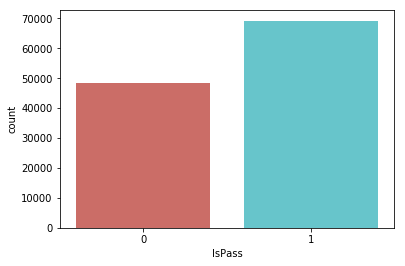

In [5]:
sns.countplot(x = 'IsPass', data = df_logit, palette = 'hls')
plt.show()

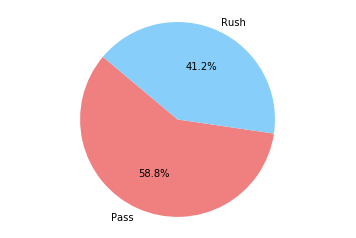

In [6]:
# Data to plot
labels = 'Pass', 'Rush'
sizes = [69221, 48517]
colors = ['lightcoral', 'lightskyblue']

# Plot
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.show()

<b>Observations from Rush and Pass group means</b>
    <ul><li>Before-play features:</li>
            <ul>Time: Slight difference</ul>
            <ul>Down: Pass play seems to happen in latter downs (1.92 vs 1.57)</ul>
            <ul>ToGo: Pass play seems to have larger Yards-to-go for the 1st down</ul>
            <ul>YardLine: Rush play has slightly closer distance towards the touchdown area</ul>
            <ul>PointDiff: Offense teams with larger point differences behind tend to pass</ul>
            <ul><b>Offense_team_pass_data</b>: It's very interesting to notice that pass play teams have lower mean (representing higher average ranking) in most pass-related team rankings, except for pass rankings like QBR ranking and yards per game ranking</ul>
            <ul><b>Offense_team_rush_data</b>: Rush play teams have lower mean (higher average ranking) in all the rush-related team rankings, which makes sense</b></ul>
            <ul><b>Defense_team_pass_data</b>: Pass play teams have generally larger opponent team's pass defense rankings, meaning that they are facing teams that are less good at defending pass, which makes sense</ul>
            <ul><b>Defense_team_rush_data</b>: Rush play teams have larger opponent team's rush defense rankings in all related features, meaning that they are facing teams with poorer rush defense rankings, which also makes sense</b></ul>
    <li>In general, teams choose to pass when facing poorer pass defenders and choose to rush when facing poorer rush defenders, which is consistent with our intuition.</li>
    <li>After-play features (play results):</li>
            <ul>Yards: Pass play have significantly larger yards. (7.4 vs 4.48)</ul>
            <ul>Pass plays are more likely to be incomplete and arouse penalties</ul>
    


In [7]:
df_logit.groupby('IsPass').mean().iloc[:,:12]

,GameId,Quarter,Minute,Second,Remaining,Down,ToGo,YardLine,SeriesFirstDown,SeasonYear,Yards,IsRush
IsPass,,,,,,,,,,,,
0,2.017489e+09,2.517860,7.202012,28.683266,1794.730218,1.573613,8.241482,48.804769,0.222932,2017.366861,4.484160,1.0
1,2.017484e+09,2.578452,6.447292,28.514136,1694.745193,1.926973,8.950579,47.851375,0.327516,2017.362578,7.406264,0.0


In [8]:
df_logit.groupby('IsPass').mean().iloc[:,11:22]

,IsRush,IsIncomplete,IsTouchdown,IsChallenge,IsChallengeReversed,IsInterception,IsFumble,IsPenalty,YardLineFixed,IsPenaltyAccepted,IsNoPlay
IsPass,,,,,,,,,,,
0,1.0,0.000000,0.034132,0.002267,0.000783,0.000000,0.009481,0.054682,28.323742,0.049220,0.031144
1,0.0,0.358258,0.047124,0.007108,0.003048,0.023851,0.008653,0.087719,29.674752,0.070701,0.057829


In [9]:
df_logit.groupby('IsPass').mean().iloc[:,21:29]

,IsNoPlay,PenaltyYards,PointDiff,Off_Pass_Cmp_rank,Off_Pass_Att_rank,Off_Pass_Cmp%_rank,Off_Pass_TD_rank,Off_Pass_Int%_rank
IsPass,,,,,,,,
0,0.031144,0.441783,-0.302286,2.707608,2.570955,2.522683,2.811241,2.176515
1,0.057829,0.727366,-2.881163,2.598200,2.445067,2.526459,2.800378,2.189162


In [10]:
df_logit.groupby('IsPass').mean().iloc[:,28:35]

,Off_Pass_Int%_rank,Off_Pass_Sk%_rank,Off_Pass_Yds_rank,Off_Pass_Y/G_rank,Off_Pass_Y/A_rank,Off_Pass_QBR_rank,Off_Rush_Att_rank
IsPass,,,,,,,
0,2.176515,2.275821,2.618319,2.618319,2.519694,2.381598,2.775275
1,2.189162,2.240129,2.542480,2.542480,2.557273,2.409471,2.911616


In [11]:
df_logit.groupby('IsPass').mean().iloc[:,34:41]

,Off_Rush_Att_rank,Off_Rush_Yds_rank,Off_Rush_Y/G_rank,Off_Rush_Y/A_rank,Off_Rush_TD_rank,Def_Pass_Cmp_rank,Def_Pass_Att_rank
IsPass,,,,,,,
0,2.775275,2.772451,2.772451,2.543541,2.906115,2.498403,2.312571
1,2.911616,2.896188,2.896188,2.585762,2.976828,2.569899,2.410468


In [12]:
df_logit.groupby('IsPass').mean().iloc[:,40:47]

,Def_Pass_Att_rank,Def_Pass_Cmp%_rank,Def_Pass_TD_rank,Def_Pass_Int%_rank,Def_Pass_Sk%_rank,Def_Pass_Yds_rank,Def_Pass_Y/G_rank
IsPass,,,,,,,
0,2.312571,2.393244,2.661521,2.597935,2.701672,2.910588,2.910588
1,2.410468,2.384060,2.658413,2.586412,2.705884,2.950579,2.950579


In [13]:
df_logit.groupby('IsPass').mean().iloc[:,46:53]

,Def_Pass_Y/G_rank,Def_Pass_Y/A_rank,Def_Rush_Att_rank,Def_Rush_Yds_rank,Def_Rush_Y/G_rank,Def_Rush_Y/A_rank,Def_Rush_TD_rank
IsPass,,,,,,,
0,2.910588,2.717192,2.454253,2.270503,2.270503,2.676464,2.227755
1,2.950579,2.683608,2.337008,2.178038,2.178038,2.649239,2.170859


In [14]:
df_logit.groupby('IsPass').mean().iloc[:,52:]

,Def_Rush_TD_rank,Off_Pass_Overall_rank,Off_Rush_Overall_rank,Def_Pass_Overall_rank,Def_Rush_Overall_rank
IsPass,,,,,
0,2.227755,2.466455,2.917246,2.592906,2.271328
1,2.170859,2.416377,3.059389,2.621184,2.163375


<b>Categorical means</b>
<li>Shotgun (also no huddle shotgun) tends to be used for pass play, under center (also no huddle) tends to be used for rush play</li>
<li>The data points of field goal, punt and wildcat are so few. So we decide to <b>drop these three types of play</b> and only consider the other four main formations</li>

In [15]:
df_logit.groupby('Formation').mean()['IsPass']

Formation
FIELD GOAL           1.000000
NO HUDDLE            0.401932
NO HUDDLE SHOTGUN    0.777791
PUNT                 1.000000
SHOTGUN              0.743874
UNDER CENTER         0.318748
WILDCAT              0.000000
Name: IsPass, dtype: float64

In [16]:
df_logit['Formation'].value_counts()

SHOTGUN              64765
UNDER CENTER         42212
NO HUDDLE SHOTGUN     8681
NO HUDDLE             2070
WILDCAT                  5
PUNT                     3
FIELD GOAL               2
Name: Formation, dtype: int64

In [17]:
# df[(df['Formation']=='FIELD GOAL') | (df['Formation']=='PUNT') | (df['Formation']=='WILDCAT')]['Formation']
# df[(df['Formation']=='FIELD GOAL') | (df['Formation']=='PUNT') | (df['Formation']=='WILDCAT')].index

In [18]:
# df_logit['IsShotgun'] = np.where((df_logit['Formation']=='SHOTGUN') | (df_logit['Formation']=='NO HUDDLE SHOTGUN'), 1, 0)
# df_logit['IsUndercenter'] = np.where((df_logit['Formation']=='UNDER CENTER') | (df_logit['Formation']=='NO HUDDLE'), 1, 0)
# df_logit[['Formation','IsShotgun','IsUndercenter']]
# (df_logit['IsShotgun']+df_logit['IsUndercenter']).unique()

<b>Generate 4 binary variables of the four formations</b>

In [19]:
df_logit.drop(index = df[(df['Formation']=='FIELD GOAL') | (df['Formation']=='PUNT') | (df['Formation']=='WILDCAT')].index, inplace=True)
df_logit['IsHuddleShotgun'] = np.where(df_logit['Formation']=='SHOTGUN', 1, 0)
df_logit['IsHuddleUndercenter'] = np.where(df_logit['Formation']=='UNDER CENTER', 1, 0)
df_logit['IsNohuddleShotgun'] = np.where((df_logit['Formation']=='NO HUDDLE SHOTGUN'), 1, 0)
df_logit['IsNohuddleUndercenter'] = np.where((df_logit['Formation']=='NO HUDDLE'), 1, 0)
df_logit[['Formation','IsHuddleShotgun','IsHuddleUndercenter','IsNohuddleShotgun','IsNohuddleUndercenter']]
# (df_logit['IsHuddleShotgun']+df_logit['IsHuddleUndercenter']+df_logit['IsNohuddleShotgun']+df_logit['IsNohuddleUndercenter']).unique()

,Formation,IsHuddleShotgun,IsHuddleUndercenter,IsNohuddleShotgun,IsNohuddleUndercenter
0,SHOTGUN,1,0,0,0
1,SHOTGUN,1,0,0,0
2,SHOTGUN,1,0,0,0
3,SHOTGUN,1,0,0,0
4,SHOTGUN,1,0,0,0
...,...,...,...,...,...
117733,UNDER CENTER,0,1,0,0
117734,SHOTGUN,1,0,0,0
117735,UNDER CENTER,0,1,0,0
117736,UNDER CENTER,0,1,0,0


In [20]:
df_logit['PassType'].unique()

array(['SHORT LEFT', 'SHORT RIGHT', 'SHORT MIDDLE', 'DEEP LEFT', nan,
       'DEEP RIGHT', 'DEEP MIDDLE'], dtype=object)

In [21]:
# df_logit[['IsIncomplete','IsPass']]
print(len(df_logit[(df_logit['IsIncomplete']==1) & (df_logit['IsPass']==1)]['IsIncomplete']))
print(len(df_logit[(df_logit['IsIncomplete']==1) & (df_logit['IsPass']==0)]['IsIncomplete']))
print(len(df_logit[(df_logit['IsIncomplete']==0) & (df_logit['IsPass']==1)]['IsIncomplete']))
print(len(df_logit[(df_logit['IsIncomplete']==0) & (df_logit['IsPass']==0)]['IsIncomplete']))

24798
0
44418
48512


<b>Generate 3 cumulative variables and 1 distance_to_touchdown variable</b>
<li>cum_intcps_in_game: Cumulated interception times in the game
<li>cum_fumbles_in_game: Cumulated fumble times in the game
<li>cum_passincplts_in_game: Cumulated pass incompletes in the game
<li>distance_to_TD: Offense Team's distance from current yard line to the TouchDown area, = 100 - YardLine

In [22]:
df_logit = df_logit.sort_values(by = ['GameId', 'Remaining'], ascending = False)
# df_logit = df_logit.reset_index(drop=True)
df_logit

,GameId,GameDate,Quarter,Minute,Second,Remaining,OffenseTeam,DefenseTeam,Down,ToGo,...,Def_Rush_Y/A_rank,Def_Rush_TD_rank,Off_Pass_Overall_rank,Off_Rush_Overall_rank,Def_Pass_Overall_rank,Def_Rush_Overall_rank,IsHuddleShotgun,IsHuddleUndercenter,IsNohuddleShotgun,IsNohuddleUndercenter
117555,2019112411,2019/11/24,1,14,53,3593,PHI,SEA,1,10,...,3,3,2,3,4,2,0,1,0,0
117556,2019112411,2019/11/24,1,14,18,3558,PHI,SEA,2,8,...,3,3,2,3,4,2,0,1,0,0
117557,2019112411,2019/11/24,1,13,39,3519,PHI,SEA,3,7,...,3,3,2,3,4,2,0,0,1,0
117558,2019112411,2019/11/24,1,13,23,3503,SEA,PHI,1,10,...,2,2,2,2,3,1,0,1,0,0
117559,2019112411,2019/11/24,1,12,45,3465,SEA,PHI,2,8,...,2,2,2,2,3,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6168,2016090800,2016/09/08,4,0,51,51,CAR,DEN,1,10,...,3,2,3,3,1,3,1,0,0,0
6169,2016090800,2016/09/08,4,0,42,42,CAR,DEN,2,10,...,3,2,3,3,1,3,1,0,0,0
6170,2016090800,2016/09/08,4,0,36,36,CAR,DEN,2,10,...,3,2,3,3,1,3,1,0,0,0
6171,2016090800,2016/09/08,4,0,29,29,CAR,DEN,3,10,...,3,2,3,3,1,3,0,0,1,0


In [23]:
# len(df_logit[df_logit['GameId'] == 2016091105])    
# df_logit[df_logit['GameId'] == 2016091105]
# len(df_logit['GameId'].unique())
# df_logit['GameId'].unique()
# df_logit[df_logit['GameId'] == 2016091105][:30]['IsIncomplete']

In [24]:
def gen_cum_data(col):
    uniqueid_array = df_logit['GameId'].unique()
    result_list = list()
    
    for j in range(len(uniqueid_array)):
        df_list = list()
        subdf = df_logit[df_logit['GameId'] == uniqueid_array[j]]
        for i in range(len(subdf)):
            df_list.append(sum(subdf[:i][col]))
        result_list.extend(df_list)
        
    return result_list

In [25]:
df_logit['distance_to_TD'] = 100 - df_logit['YardLine']
df_logit['cum_intcps_in_game'] = gen_cum_data('IsInterception')
# df_logit[['Remaining','IsInterception','cum_intcps_in_game']][:40]
df_logit['cum_fumbles_in_game'] = gen_cum_data('IsFumble')
df_logit['cum_passincplts_in_game'] = gen_cum_data('IsIncomplete')

In [26]:
df_logit[['GameId','Remaining','distance_to_TD','IsIncomplete','cum_passincplts_in_game','IsFumble','cum_fumbles_in_game','IsInterception','cum_intcps_in_game']][30000:30030]

,GameId,Remaining,distance_to_TD,IsIncomplete,cum_passincplts_in_game,IsFumble,cum_fumbles_in_game,IsInterception,cum_intcps_in_game
67715,2018120211,1369,1,0,12,0,0,0,1
82063,2018120211,1356,76,0,12,0,0,0,1
82062,2018120211,1320,72,0,12,0,0,0,1
82061,2018120211,1284,68,0,12,0,0,0,1
82060,2018120211,1258,68,0,12,0,0,0,1
82059,2018120211,1219,65,0,12,0,0,0,1
82058,2018120211,1180,64,0,12,0,0,0,1
67714,2018120211,1138,46,0,12,0,0,0,1
67713,2018120211,1102,43,0,12,0,0,0,1
67712,2018120211,1074,35,1,12,0,0,0,1


In [ ]:
# df_logit['PenaltyYards'].hist()

In [ ]:
# df_logit.columns[65:]

<b>Drop 53 after-play features and redundant features</b>
- Drop features that are results of plays.
- Drop redundant categorical features.
- Drop team featues that are redundant, e.g. completion rate could be calculated from total completions/total attempts, thus should be droped.

In [27]:
la = ['Off_Pass_Cmp', 'Off_Pass_Att','Off_Pass_Cmp_pct', 'Off_Pass_TD', 'Off_Pass_Int_pct','Off_Pass_Sk_pct',\
                         'Off_Pass_Yds', 'Off_Pass_YperG', 'Off_Pass_YperA', 'Off_Pass_QBR', 'Off_Rush_Att', 'Off_Rush_Yds', \
                         'Off_Rush_YperG', 'Off_Rush_YperA', 'Off_Rush_TD', 'Def_Pass_Cmp', 'Def_Pass_Att', 'Def_Pass_Cmp_pct', \
                         'Def_Pass_TD', 'Def_Pass_Int_pct', 'Def_Pass_Sk_pct', 'Def_Pass_Yds', 'Def_Pass_YperG', 'Def_Pass_YperA',\
                         'Def_Rush_Att', 'Def_Rush_Yds', 'Def_Rush_YperG', 'Def_Rush_YperA','Def_Rush_TD', 'Off_Pass_Overall', \
                         'Off_Rush_Overall','Def_Pass_Overall', 'Def_Rush_Overall']
lb = ['SeriesFirstDown', 'PlayType','IsIncomplete', 'IsTouchdown', 'IsChallenge', 'IsChallengeReversed',\
                                    'IsInterception','IsFumble', 'IsPenalty','IsPenaltyAccepted', 'PenaltyTeam', 'IsNoPlay','PenaltyType', \
                                    'PenaltyYards']

lc = ['Off_Pass_Cmp%_rank','Def_Pass_Cmp%_rank','Off_Pass_Yds_rank','Def_Pass_Yds_rank','Off_Rush_Yds_rank',\
                                    'Def_Rush_Yds_rank']

print(len(la)+len(lb)+len(lc))

53


In [28]:
df_logit = df_logit.drop(columns = ['SeriesFirstDown', 'PlayType','IsIncomplete', 'IsTouchdown', 'IsChallenge', 'IsChallengeReversed',\
                                    'IsInterception','IsFumble', 'IsPenalty','IsPenaltyAccepted', 'PenaltyTeam', 'IsNoPlay','PenaltyType', \
                                    'PenaltyYards'])

df_logit = df_logit.drop(columns = ['Off_Pass_Cmp', 'Off_Pass_Att','Off_Pass_Cmp_pct', 'Off_Pass_TD', 'Off_Pass_Int_pct','Off_Pass_Sk_pct',\
                         'Off_Pass_Yds', 'Off_Pass_YperG', 'Off_Pass_YperA', 'Off_Pass_QBR', 'Off_Rush_Att', 'Off_Rush_Yds', \
                         'Off_Rush_YperG', 'Off_Rush_YperA', 'Off_Rush_TD', 'Def_Pass_Cmp', 'Def_Pass_Att', 'Def_Pass_Cmp_pct', \
                         'Def_Pass_TD', 'Def_Pass_Int_pct', 'Def_Pass_Sk_pct', 'Def_Pass_Yds', 'Def_Pass_YperG', 'Def_Pass_YperA',\
                         'Def_Rush_Att', 'Def_Rush_Yds', 'Def_Rush_YperG', 'Def_Rush_YperA','Def_Rush_TD', 'Off_Pass_Overall', \
                         'Off_Rush_Overall','Def_Pass_Overall', 'Def_Rush_Overall'])

df_logit = df_logit.drop(columns = ['Off_Pass_Cmp%_rank','Def_Pass_Cmp%_rank','Off_Pass_Yds_rank','Def_Pass_Yds_rank','Off_Rush_Yds_rank',\
                                    'Def_Rush_Yds_rank'])

df_logit

,GameId,GameDate,Quarter,Minute,Second,Remaining,OffenseTeam,DefenseTeam,Down,ToGo,...,Def_Pass_Overall_rank,Def_Rush_Overall_rank,IsHuddleShotgun,IsHuddleUndercenter,IsNohuddleShotgun,IsNohuddleUndercenter,distance_to_TD,cum_intcps_in_game,cum_fumbles_in_game,cum_passincplts_in_game
117555,2019112411,2019/11/24,1,14,53,3593,PHI,SEA,1,10,...,4,2,0,1,0,0,63,0,0,0
117556,2019112411,2019/11/24,1,14,18,3558,PHI,SEA,2,8,...,4,2,0,1,0,0,61,0,0,0
117557,2019112411,2019/11/24,1,13,39,3519,PHI,SEA,3,7,...,4,2,0,0,1,0,60,0,0,0
117558,2019112411,2019/11/24,1,13,23,3503,SEA,PHI,1,10,...,3,1,0,1,0,0,78,0,0,1
117559,2019112411,2019/11/24,1,12,45,3465,SEA,PHI,2,8,...,3,1,1,0,0,0,76,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6168,2016090800,2016/09/08,4,0,51,51,CAR,DEN,1,10,...,1,3,1,0,0,0,53,3,1,18
6169,2016090800,2016/09/08,4,0,42,42,CAR,DEN,2,10,...,1,3,1,0,0,0,53,3,1,19
6170,2016090800,2016/09/08,4,0,36,36,CAR,DEN,2,10,...,1,3,1,0,0,0,53,3,1,20
6171,2016090800,2016/09/08,4,0,29,29,CAR,DEN,3,10,...,1,3,0,0,1,0,53,3,1,21


<b>Shuffle the dataset</b>
- Since the df_logit dataframe is ordered by gamedate and remaining time, which may influence the randomness of our sampling, we shuffle the df_logit dataset and assign it to a temporary dataset df_tmp

In [29]:
df_tmp = df_logit.sample(frac = 1).reset_index(drop = True)  # shuffle the original data set
df_tmp

,GameId,GameDate,Quarter,Minute,Second,Remaining,OffenseTeam,DefenseTeam,Down,ToGo,...,Def_Pass_Overall_rank,Def_Rush_Overall_rank,IsHuddleShotgun,IsHuddleUndercenter,IsNohuddleShotgun,IsNohuddleUndercenter,distance_to_TD,cum_intcps_in_game,cum_fumbles_in_game,cum_passincplts_in_game
0,2017111206,2017/11/12,2,5,41,2141,TEN,CIN,1,9,...,2,4,0,1,0,0,9,0,0,7
1,2018102810,2018/10/28,3,0,25,925,GB,LAR,1,10,...,2,2,0,0,1,0,33,0,0,26
2,2016101604,2016/10/16,3,0,59,959,CIN,NE,3,2,...,2,1,1,0,0,0,50,0,0,16
3,2017122406,2017/12/24,1,11,26,3386,LAC,NYJ,2,7,...,3,3,1,0,0,0,96,0,0,1
4,2017123102,2017/12/31,4,2,10,130,GB,DET,1,10,...,3,4,1,0,0,0,64,2,1,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117723,2016111000,2016/11/10,2,12,27,2547,BAL,CLE,2,8,...,3,4,0,1,0,0,25,1,0,7
117724,2016101601,2016/10/16,4,11,34,694,CHI,JAX,1,10,...,2,3,0,1,0,0,28,1,0,30
117725,2016112009,2016/11/20,3,12,23,1643,SF,NE,1,10,...,2,1,1,0,0,0,69,0,1,8
117726,2017121705,2017/12/17,3,12,18,1638,NO,NYJ,2,4,...,3,3,0,1,0,0,87,1,0,13


In [30]:
# df_test = df_tmp[round(0.9*len(df_tmp)):]  # take 10% of the original data set as the test set, which is randomly chosen
# df_train = df_tmp[:round(0.9*len(df_tmp))]   #take 90% of the original data set as the training set
# df_test.to_csv(r'C:\Users\zhong\Downloads\pbp_test_data.csv', index = False)
# df_train.to_csv(r'C:\Users\zhong\Downloads\pbp_train_data.csv', index = False)

<b>Split the dataset to training set and testing set</b>
- We leave 20% of the original dataset as the testing set, and use 80% of the original data as the training set
- And export the two datasets as csv format

In [31]:
data, test = train_test_split(df_tmp, test_size = 0.2, random_state = 10)

In [32]:
data.to_csv(r'C:\Users\zhong\Downloads\pbp_modeling_data.csv',index = False)

In [33]:
test.to_csv(r'C:\Users\zhong\Downloads\pbp_testing_data.csv',index = False)

In [34]:
data.describe()

,GameId,Quarter,Minute,Second,Remaining,Down,ToGo,YardLine,SeasonYear,Yards,...,Def_Pass_Overall_rank,Def_Rush_Overall_rank,IsHuddleShotgun,IsHuddleUndercenter,IsNohuddleShotgun,IsNohuddleUndercenter,distance_to_TD,cum_intcps_in_game,cum_fumbles_in_game,cum_passincplts_in_game
count,9.418200e+04,94182.000000,94182.000000,94182.000000,94182.000000,94182.000000,94182.000000,94182.000000,94182.000000,94182.000000,...,94182.000000,94182.000000,94182.000000,94182.000000,94182.000000,94182.000000,94182.000000,94182.000000,94182.000000,94182.000000
mean,2.017487e+09,2.553195,6.753987,28.518093,1735.881920,1.780234,8.660200,48.223663,2017.365027,6.188507,...,2.610732,2.205029,0.548682,0.359772,0.074101,0.017445,51.776337,0.773311,0.532437,12.811779
std,1.058984e+06,1.128737,4.514385,17.761872,1055.724838,0.814752,3.996027,24.430102,1.074169,9.014051,...,0.787377,1.061287,0.497627,0.479936,0.261937,0.130923,24.430102,1.003303,0.786498,8.697750
min,2.016091e+09,1.000000,0.000000,0.000000,-898.000000,0.000000,0.000000,1.000000,2016.000000,-23.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.016122e+09,2.000000,3.000000,13.000000,829.000000,1.000000,6.000000,27.000000,2016.000000,0.000000,...,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,33.000000,0.000000,0.000000,5.000000
50%,2.017122e+09,3.000000,7.000000,28.000000,1800.000000,2.000000,10.000000,44.000000,2017.000000,4.000000,...,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000,56.000000,0.000000,0.000000,12.000000
75%,2.018121e+09,4.000000,11.000000,44.000000,2632.000000,2.000000,10.000000,67.000000,2018.000000,9.000000,...,3.000000,3.000000,1.000000,1.000000,0.000000,0.000000,73.000000,1.000000,1.000000,19.000000
max,2.019112e+09,5.000000,15.000000,59.000000,3600.000000,4.000000,43.000000,99.000000,2019.000000,104.000000,...,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,99.000000,7.000000,6.000000,47.000000


In [35]:
test.describe()

,GameId,Quarter,Minute,Second,Remaining,Down,ToGo,YardLine,SeasonYear,Yards,...,Def_Pass_Overall_rank,Def_Rush_Overall_rank,IsHuddleShotgun,IsHuddleUndercenter,IsNohuddleShotgun,IsNohuddleUndercenter,distance_to_TD,cum_intcps_in_game,cum_fumbles_in_game,cum_passincplts_in_game
count,2.354600e+04,23546.000000,23546.000000,23546.000000,23546.000000,23546.000000,23546.000000,23546.000000,23546.000000,23546.000000,...,23546.000000,23546.000000,23546.000000,23546.000000,23546.000000,23546.000000,23546.000000,23546.000000,23546.000000,23546.000000
mean,2.017483e+09,2.554744,6.775758,28.850166,1736.126136,1.785569,8.650259,48.323877,2017.361463,6.258685,...,2.604689,2.219358,0.555891,0.353691,0.072284,0.018135,51.676123,0.788244,0.526714,12.813726
std,1.062650e+06,1.125808,4.503424,17.708960,1053.448232,0.813100,3.983769,24.322352,1.077001,8.978357,...,0.789140,1.063857,0.496877,0.478125,0.258963,0.133441,24.322352,1.013944,0.776532,8.677725
min,2.016091e+09,1.000000,0.000000,0.000000,-898.000000,0.000000,0.000000,1.000000,2016.000000,-12.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.016122e+09,2.000000,3.000000,14.000000,840.000000,1.000000,6.000000,28.000000,2016.000000,0.000000,...,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,33.000000,0.000000,0.000000,5.000000
50%,2.017122e+09,3.000000,7.000000,29.000000,1800.000000,2.000000,10.000000,45.000000,2017.000000,4.000000,...,3.000000,2.000000,1.000000,0.000000,0.000000,0.000000,55.000000,0.000000,0.000000,12.000000
75%,2.018121e+09,4.000000,11.000000,44.000000,2620.000000,2.000000,10.000000,67.000000,2018.000000,9.000000,...,3.000000,3.000000,1.000000,1.000000,0.000000,0.000000,72.000000,1.000000,1.000000,19.000000
max,2.019112e+09,5.000000,15.000000,59.000000,3600.000000,4.000000,44.000000,99.000000,2019.000000,99.000000,...,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,99.000000,7.000000,6.000000,46.000000


# Logistic models using all the features

<b>Several Logistic Regression Assumptions that we keep in mind</b>
<li>1. Binary logistic regression requires the dependent variable to be binary.
<li>2. For a binary regression, the factor level 1 of the dependent variable should represent the desired outcome.
<li>3. Only the meaningful variables should be included.
<li>4. The independent variables should be independent of each other. That is, the model should have little or no multicollinearity.
<li>5. The independent variables are linearly related to the log odds.
<li>6. Logistic regression requires quite large sample sizes.

<b>Linear regression of Y (IsPass) on all features</b>
<li>We find not all features are statistically significant. In fact, only 23 out of 43 features are significant.
<li>To avoid multicollinearity, we should not include all features in the logistic model.
<li>However, since our goal is maximize the accuracy prediction of our models, we'll both include all the features and only use significant features in all the following models to see which choice yields a more accurate result.


In [36]:
unused_features = ['GameId', 'GameDate', 'OffenseTeam','DefenseTeam', 'YardLine', 'Description','Yards','Formation', 'IsRush','IsPass','PassType','RushDirection','YardLineFixed','YardLineDirection']
features = [i for i in df_tmp.columns.tolist() if i not in unused_features]
print('# of all features: ',len(df_tmp.columns.tolist()))
print('# of unused variables: ',len(unused_features))
print('# of used features: ',len(features))

# of all features:  57
# of unused variables:  14
# of used features:  43


In [37]:
feature_list_2 = ['Quarter', 'Minute', 'Second', 'Remaining', 'Down', 'ToGo', 'SeasonYear', 'PointDiff', 'Off_Pass_Overall_rank', \
                'Off_Rush_Overall_rank', 'Def_Pass_Overall_rank', 'Def_Rush_Overall_rank', 'IsHuddleShotgun', 'IsHuddleUndercenter', \
                'IsNohuddleShotgun', 'IsNohuddleUndercenter','distance_to_TD', 'cum_intcps_in_game', 'cum_fumbles_in_game', \
                'cum_passincplts_in_game']
print('# of feature_list2: ',len(feature_list_2))

# of feature_list2:  20


<b>Split the training dataset to 80% traindata & 20% testdata</b>
- 'data': 80% of the whole pbp dataset, used for training models
- 'Testdata': 20% of the whole pbp dataset, used for testing models
- 'traindata': 80% of the 'data', used for training models
- 'testdata'： 20% of the 'data', used for testing models and cross validation

In [38]:
traindata, testdata = train_test_split(data,test_size = 0.2,random_state = 10)

In [39]:
X = traindata[features]
y = traindata['IsPass']

<b>Try different combinations of hyperparameters, get a broad sense of how accurate the logistic model could be</b>
- Model7 with penalty = 'l1' and max_iter = 200 seems to yield the highest testing accuracy.

In [40]:
logit_model1 = linear_model.LogisticRegression()
logit_model1.fit(X,y)
print('training accuracy: ', logit_model1.score(X,y))
print('testing accuracy: ', logit_model1.score(testdata[features],testdata['IsPass']))

training accuracy:  0.7200610524918707
testing accuracy:  0.7186388490736317


In [41]:
logit_model2 = linear_model.LogisticRegression(max_iter = 300)
logit_model2.fit(X,y)
print('training accuracy: ', logit_model2.score(X,y))
print('testing accuracy: ', logit_model2.score(testdata[features],testdata['IsPass']))

training accuracy:  0.7200610524918707
testing accuracy:  0.7186388490736317


In [42]:
logit_model3 = linear_model.LogisticRegression(solver = 'newton-cg',max_iter = 200)
logit_model3.fit(X,y)
print('training accuracy: ', logit_model3.score(X,y))
print('testing accuracy: ', logit_model3.score(testdata[features],testdata['IsPass']))

D:\Anaconda\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\Anaconda\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


training accuracy:  0.7201406861769195
testing accuracy:  0.7191697191697192


D:\Anaconda\lib\site-packages\scipy\optimize\linesearch.py:422: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
D:\Anaconda\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


In [43]:
logit_model4 = linear_model.LogisticRegression(solver = 'liblinear',max_iter = 200)
logit_model4.fit(X,y)
print('training accuracy: ', logit_model4.score(X,y))
print('testing accuracy: ', logit_model4.score(testdata[features],testdata['IsPass']))

training accuracy:  0.7200610524918707
testing accuracy:  0.7186388490736317


In [44]:
logit_model5 = linear_model.LogisticRegression(solver = 'sag',max_iter = 200)
logit_model5.fit(X,y)
print('training accuracy: ', logit_model5.score(X,y))
print('testing accuracy: ', logit_model5.score(testdata[features],testdata['IsPass']))

training accuracy:  0.6807618289202999
testing accuracy:  0.6753729362425015


D:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [45]:
logit_model6 = linear_model.LogisticRegression(solver = 'saga',max_iter = 200)
logit_model6.fit(X,y)
print('training accuracy: ', logit_model6.score(X,y))
print('testing accuracy: ', logit_model6.score(testdata[features],testdata['IsPass']))

training accuracy:  0.6518813458092774
testing accuracy:  0.6469182990922121


D:\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [46]:
logit_model7 = linear_model.LogisticRegression(penalty='l1',max_iter = 200)
logit_model7.fit(X,y)
print('training accuracy: ', logit_model7.score(X,y))
print('testing accuracy: ', logit_model7.score(testdata[features],testdata['IsPass']))

training accuracy:  0.7201008693343951
testing accuracy:  0.7186388490736317


In [47]:
logit_model8 = linear_model.LogisticRegression(penalty='l1',max_iter = 300)
logit_model8.fit(X,y)
print('training accuracy: ', logit_model8.score(X,y))
print('testing accuracy: ', logit_model8.score(testdata[features],testdata['IsPass']))

training accuracy:  0.7200875970535536
testing accuracy:  0.7186388490736317


In [49]:
logit_model9 = linear_model.LogisticRegression(solver = 'newton-cg',max_iter = 300)
logit_model9.fit(X,y)
print('training accuracy: ', logit_model9.score(X,y))
print('testing accuracy: ', logit_model9.score(testdata[features],testdata['IsPass']))

D:\Anaconda\lib\site-packages\scipy\optimize\linesearch.py:462: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
D:\Anaconda\lib\site-packages\scipy\optimize\linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


training accuracy:  0.7201406861769195
testing accuracy:  0.7191697191697192


D:\Anaconda\lib\site-packages\scipy\optimize\linesearch.py:422: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
D:\Anaconda\lib\site-packages\sklearn\utils\optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


<b>Use GridSearchCV to find the best combination of hyperparameters</b>
- Due to computational and time cost, we can't list all possible combinations of all the hyperparameters of logistic models.
- Therefore, we only set a few hyperparameters, which we deem as the most influential in model results, and try their combinations.
- Since model9 with the newton-cg solver <b>didn't converge</b>, we don't consider it as an option in our GridSearchCV parameters.

In [63]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
# C = np.logspace(0, 4, 10)

# Create max_iter hyperparameter space
max_iter = [100,120,140,160,180,200,220,240,260] 

# Create hyperparameter options
hyperparameters = dict(penalty=penalty,max_iter=max_iter)

In [64]:
from sklearn.model_selection import GridSearchCV
# Create grid search using 5-fold cross validation
logistic_t = linear_model.LogisticRegression()
clf = GridSearchCV(logistic_t, hyperparameters, cv=15, verbose=0)

In [65]:
# Fit grid search
best_model_test = clf.fit(X, y)

In [66]:
# View best hyperparameters
print('Best Penalty:', best_model_test.best_estimator_.get_params()['penalty'])
print('Best max_iter:', best_model_test.best_estimator_.get_params()['max_iter'])
print('Best model training set accuracy:', best_model_test.score(X,y))
print('Best model testing set accuracy:', best_model_test.score(Testdata[features],Testdata['IsPass']))

Best Penalty: l1
Best max_iter: 220
Best model training set accuracy: 0.7200743247727122
Best model testing set accuracy: 0.7254310710948781


<b>Best model: logit_model10</b>

Compute trainset cross validation accuracy

In [70]:
logit_model10 = linear_model.LogisticRegression(penalty = 'l1',max_iter = 220)
logit_model10.fit(X,y)
print('training accuracy: ', logit_model10.score(X,y))
print('testing accuracy: ', logit_model10.score(testdata[features],testdata['IsPass']))

training accuracy:  0.7200743247727122
testing accuracy:  0.7186388490736317


In [71]:
model10_scores = cross_val_score(logit_model10, data[features], data['IsPass'], cv=15, scoring = 'accuracy')
print(model10_scores)
print('Mean score = ',model10_scores.mean())

[0.71237458 0.71364867 0.72511546 0.7176302  0.7241599  0.72272655
 0.71874502 0.72240803 0.71205606 0.71524128 0.72718586 0.72193024
 0.71922281 0.72570882 0.7212044 ]
Mean score =  0.7199571918842543


In [72]:
model7_scores = cross_val_score(logit_model7, data[features], data['IsPass'], cv=15, scoring = 'accuracy')
print(model7_scores)
print('Mean score = ',model7_scores.mean())

[0.71237458 0.71317089 0.7249562  0.7176302  0.7241599  0.72288581
 0.71874502 0.72240803 0.7118968  0.7147635  0.72718586 0.72193024
 0.71922281 0.72539025 0.7212044 ]
Mean score =  0.7198616318845431


Compute trainset cross validation accuracy
- The result is close to the training accuracy, which means our model is likely to prevent the overfitting problem. Not bad.

In [50]:
Testdata = pd.read_csv(r'C:\Users\zhong\Downloads\pbp_testing_data.csv')

In [51]:
logit_model10.score(Testdata[features], Testdata['IsPass'])

0.7254735411534868

In [202]:
model10_test_scores = cross_val_score(logit_model10, Testdata[features], Testdata['IsPass'], cv=15, scoring = 'accuracy')
print(model10_test_scores)
print('Mean score = ',model10_test_scores.mean())

[0.7281986  0.73647358 0.72119669 0.72229299 0.72611465 0.72547771
 0.72101911 0.73248408 0.72402804 0.70044614 0.71383047 0.72275335
 0.7195666  0.71574251 0.73422562]
Mean score =  0.722923342839104


<b>Also report the false negative rate</b>
- We care about this indicator because in NFL games, we're less willing to predict a Pass as a Rush (which is a false negative sample)
- This is because compared to predicting a Rush as a Pass, the defense formation is more prepared to defense a rush when they intend to defend a pass.

In [73]:
# FN / (TP + FN) 
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Testdata['IsPass'], logit_model10.predict(Testdata[features])))
tn, fp, fn, tp = confusion_matrix(Testdata['IsPass'], logit_model10.predict(Testdata[features])).ravel()
print('False Negative Rate = ', fn/(tp+fn))

[[ 5779  3689]
 [ 2775 11303]]
False Negative Rate =  0.19711606762324194


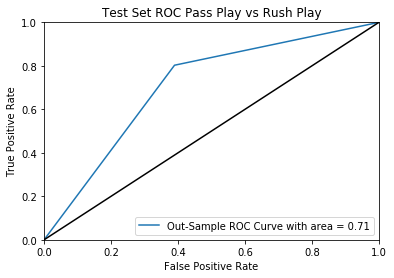

In [76]:
#training_predictions = model.predict(x_train)
#(fpr, tpr, thresholds) = roc_curve(y_train,training_predictions)
from sklearn.metrics import roc_curve, auc
testing_predictions = logit_model10.predict(Testdata[features])
(fpr, tpr, thresholds) = roc_curve(Testdata['IsPass'],testing_predictions)

area = auc(fpr,tpr)
plt.clf() #Clear the current figure
plt.plot(fpr,tpr,label="Out-Sample ROC Curve with area = %1.2f"%area)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Pass Play vs Rush Play')
plt.legend(loc="lower right")
plt.show()

<b>Logistic model only using significant features</b>

<b>Linear Regression of Y on all the features</b>
- First, we plot the correlation graph of all the features. We can see the team offense and defense ranking features are highly correlated, which may lead to multicollinearity problem.
- Then, we regress Y on all the features, finding that 23 features are statistically significant and 20 features are insignificant. We store them to lists separately.

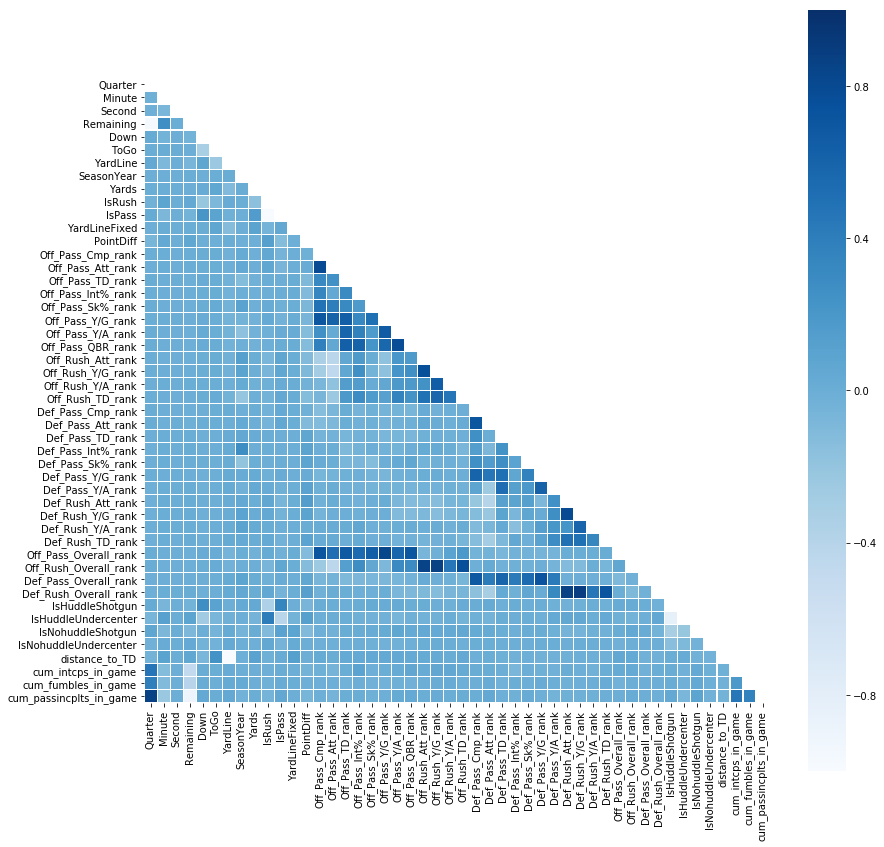

In [77]:
fig,ax = plt.subplots(figsize=(14,14))
corr = df_logit.iloc[:,2:].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,annot=False, cmap = 'Blues', mask=mask, linewidths=.1, fmt='.1f', square = True)
plt.show()

In [78]:
from statsmodels.api import OLS
OLS(data['IsPass'],data[features]).fit().summary()

D:\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 IsPass   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     609.7
Date:                Fri, 20 Dec 2019   Prob (F-statistic):               0.00
Time:                        03:43:11   Log-Likelihood:                -55872.
No. Observations:               94182   AIC:                         1.118e+05
Df Residuals:                   94140   BIC:                         1.122e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Quarter                     2.9179      0.851      3.428      0.001       1.249       4.586
Minute                     -0.1984      0.057     -3.496      0.000      -0.310      -0.087
Second                     -0.0035      0.001     -3.709      0.000      -0.005      -0.002
Remaining                   0.0032      0.001      3.430      0.001       0.001       0.005
Down                        0.0906      0.002     46.204      0.000       0.087       0.094
ToGo                        0.0129      0.000     32.686      0.000       0.012       0.014
SeasonYear                 -0.0057      0.002     -3.338      0.001      -0.009      -0.002
PointDiff                  -0.0031      0.000    -21.996      0.000      -0.003      -0.003
Off_Pass_Cmp_rank          -0.0082      0.003     -2.471      0.013      -0.015      -0.002
Off_Pass_Att_rank          -0.0047      0.004     -1.328      0.184      -0.012       0.002
Off_Pass_TD_rank            0.0038      0.002      1.522      0.128      -0.001       0.009
Off_Pass_Int%_rank         -0.0059      0.002     -2.448      0.014      -0.011      -0.001
Off_Pass_Sk%_rank          -0.0112      0.003     -4.486      0.000      -0.016      -0.006
Off_Pass_Y/G_rank          -0.0084      0.004     -2.067      0.039      -0.016      -0.000
Off_Pass_Y/A_rank          -0.0182      0.003     -5.427      0.000      -0.025      -0.012
Off_Pass_QBR_rank           0.0202      0.004      5.088      0.000       0.012       0.028
Off_Rush_Att_rank           0.0167      0.004      4.543      0.000       0.009       0.024
Off_Rush_Y/G_rank           0.0247      0.005      5.197      0.000       0.015       0.034
Off_Rush_Y/A_rank          -0.0043      0.003     -1.686      0.092      -0.009       0.001
Off_Rush_TD_rank           -0.0006      0.003     -0.189      0.850      -0.007       0.006
Def_Pass_Cmp_rank           0.0089      0.003      3.141      0.002       0.003       0.014
Def_Pass_Att_rank           0.0032      0.003      1.007      0.314      -0.003       0.009
Def_Pass_TD_rank            0.0030      0.002      1.252      0.211      -0.002       0.008
Def_Pass_Int%_rank         -0.0002      0.002     -0.115      0.909      -0.004       0.004
Def_Pass_Sk%_rank           0.0018      0.002      0.835      0.404      -0.002       0.006
Def_Pass_Y/G_rank           0.0006      0.004      0.160      0.873      -0.007       0.009
Def_Pass_Y/A_rank           0.0053      0.003      1.578      0.115      -0.001       0.012
Def_Rush_Att_rank          -0.0072      0.004     -1.875      0.061      -0.015       0.000
Def_Rush_Y/G_rank          -0.0012      0.004     -0.278      0.781      -0.010       0.007
Def_Rush_Y/A_rank          -0.0019      0.002     -0.822      0.411      -0.006       0.003
Def_Rush_TD_rank            0.0017      0.003  

In [79]:
insignificantfeatures = ['Off_Pass_Att_rank','Off_Pass_TD_rank','Off_Rush_Y/A_rank','Off_Rush_TD_rank','Def_Pass_Att_rank',\
                         'Def_Pass_TD_rank','Def_Pass_Int%_rank','Def_Pass_Sk%_rank','Def_Pass_Y/G_rank','Def_Pass_Y/A_rank',\
                        'Def_Rush_Att_rank','Def_Rush_Y/G_rank','Def_Rush_Y/A_rank','Def_Rush_TD_rank','Off_Pass_Overall_rank',\
                        'Def_Rush_Overall_rank','IsHuddleUndercenter','IsNohuddleUndercenter','cum_fumbles_in_game',\
                         'cum_passincplts_in_game']
unused_features_set = set(unused_features)
print(len(insignificantfeatures))
unused_features_set

20


{'DefenseTeam',
 'Description',
 'Formation',
 'GameDate',
 'GameId',
 'IsPass',
 'IsRush',
 'OffenseTeam',
 'PassType',
 'RushDirection',
 'YardLine',
 'YardLineDirection',
 'YardLineFixed',
 'Yards'}

In [80]:
insignificantfeatures_set = set(insignificantfeatures)
unused_features_set.update(insignificantfeatures_set)
print(len(unused_features_set))
print('# of unused features: ', len(unused_features_set))

34
# of unused features:  34


In [81]:
new_features = [i for i in data.columns.tolist() if i not in unused_features_set]
print('# of used features: ', len(new_features))
print('# of unused features: ', len(unused_features_set))
print('# of all featues: ', len(data.columns.tolist()))

# of used features:  23
# of unused features:  34
# of all featues:  57


In [82]:
print(new_features)
print(len(new_features))

['Quarter', 'Minute', 'Second', 'Remaining', 'Down', 'ToGo', 'SeasonYear', 'PointDiff', 'Off_Pass_Cmp_rank', 'Off_Pass_Int%_rank', 'Off_Pass_Sk%_rank', 'Off_Pass_Y/G_rank', 'Off_Pass_Y/A_rank', 'Off_Pass_QBR_rank', 'Off_Rush_Att_rank', 'Off_Rush_Y/G_rank', 'Def_Pass_Cmp_rank', 'Off_Rush_Overall_rank', 'Def_Pass_Overall_rank', 'IsHuddleShotgun', 'IsNohuddleShotgun', 'distance_to_TD', 'cum_intcps_in_game']
23


<b>Use the best model with the same hyperparameters</b>
- Finding: Using significant features doesn't improve prediction accuracy. Instead, the accuracy falls a little bit.Therefore, we still choose the model that uses all the features as our best logistic model.

In [83]:
logit_model10_new = linear_model.LogisticRegression(penalty='l1',max_iter = 220)
logit_model10_new.fit(traindata[new_features],traindata['IsPass'])
print('training accuracy: ', logit_model10_new.score(traindata[new_features],traindata['IsPass']))
print('testing accuracy: ', logit_model10_new.score(testdata[new_features],testdata['IsPass']))

training accuracy:  0.7192116265180171
testing accuracy:  0.7195413282369804


In [85]:
new_model10_new_scores = cross_val_score(logit_model10_new, data[new_features], data['IsPass'], cv=15, scoring = 'accuracy')
print(new_model10_new_scores)
print('Mean score = ',new_model10_new_scores.mean())

[0.71301163 0.71380793 0.72575251 0.71794872 0.72320433 0.72240803
 0.71747093 0.72240803 0.71110049 0.7147635  0.72670807 0.72145246
 0.71810798 0.72443453 0.7199299 ]
Mean score =  0.7195006030083232


<b>Compute Testdata accuracy by quarter and by down</b>

<b>Testdata accuracy by quarter</b>

In [86]:
Testdata['Quarter'].unique()

array([2, 1, 3, 4, 5], dtype=int64)

In [87]:
def gen_df_byquarter():
    logit_quarter_list = list()
    for i in range(5):
        logit_quarter_list.append(logit_model7.score(Testdata[Testdata['Quarter'] == i+1][features], \
                                                     Testdata[Testdata['Quarter'] == i+1]['IsPass']))
    return logit_quarter_list

In [88]:
logit_quarter_list = gen_df_byquarter()
logit_quarter_list

[0.6956275914059555,
 0.7256154565285136,
 0.6906382196064006,
 0.7802056555269923,
 0.7639751552795031]

<b>Testdata accuracy by down</b>

In [89]:
def gen_df_bydown():
    logit_down_list = list()
    for i in range(4):
        logit_down_list.append(logit_model7.score(Testdata[Testdata['Down'] == i+1][features], \
                                                     Testdata[Testdata['Down'] == i+1]['IsPass']))
    return logit_down_list

logit_down_list = gen_df_bydown()
logit_down_list

[0.679493285074769, 0.7104898627376904, 0.8451029844472467, 0.8213256484149856]

# KNN models
- We find in some literature review that other researchers also try K-Nearest Neighbors to predict pass/rush decision.
- Therefore, we also use KNN models to see whether the result is different. We try different K, which is the haperparameter in the model, from 1 to 49, and use cross validation to improve accuracy robustness.
- The result shows that KNN model seems to perfrom poorly on our dataset, with <b>accuracy less than 60%</b>.
- From the graph describing the relationship between cross-validation accuracy and value of K we can see that the trend of accuracy is roughly upward, which means the accuracy improves as k increases. However, as K gets larger, the increment of accuracy gets smaller. We feel that even we increase K again, the final accuracy of KNN model can't be too far away from 60%.
- In a word, <b>KNN model is not a good choice for our dataset.</b>

In [ ]:
# data

In [ ]:
# data[features]

In [ ]:
# data['IsPass']

In [90]:
k_range = range(1, 50)
# empty list to store scores
k_scores = []

# 1. we will loop through reasonable values of k
for k in k_range:
    # 2. run KNeighborsClassifier with k neighbours
    knn = KNeighborsClassifier(n_neighbors=k)
    # 3. obtain cross_val_score for KNeighborsClassifier with k neighbours
    scores = cross_val_score(knn, data[features], data['IsPass'], cv=10, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())

print(k_scores)
print('Length of list', len(k_scores))
print('Max of list', max(k_scores))

[0.5758956729450129, 0.5384256905826157, 0.5789322036796604, 0.5579305113380751, 0.5820752669493873, 0.5683890023246949, 0.5852818181653362, 0.5752055344845297, 0.5876070151013599, 0.5792934016498342, 0.5892741078574508, 0.5807799100795875, 0.5895182331338142, 0.5828926620215447, 0.5901658129184328, 0.584718966771853, 0.5907392608489058, 0.5856639465487219, 0.5910153922208797, 0.586492176056993, 0.5925974262667039, 0.5877770017603028, 0.5929478732450498, 0.589475840185471, 0.5924170223078431, 0.5895820130724282, 0.5936379936583227, 0.5898686462845345, 0.5944130070696636, 0.5901553493921112, 0.5934148483977058, 0.5904418800134411, 0.5942323607288458, 0.5922468744331814, 0.5952836081067677, 0.5942217833469658, 0.5957295705510053, 0.5934572886918442, 0.5958038748894825, 0.593744052680145, 0.5966851806948836, 0.5941900016052553, 0.5968019817002516, 0.5959419681952067, 0.5977681534424821, 0.5960586654786753, 0.5978212692036993, 0.5963029395710215, 0.5979167655053835]
Length of list 49
Max o

Text(0,0.5,'Cross-validated accuracy')

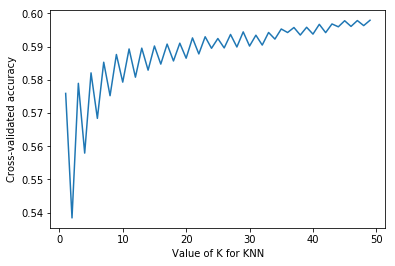

In [91]:
# plot how accuracy changes as we vary k
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
# plt.plot(x_axis, y_axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

# Random Forest Models

In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

In [94]:
# data = pd.read_csv(r'C:\Users\zhong\Downloads\pbp_modeling_data.csv')
data

,GameId,GameDate,Quarter,Minute,Second,Remaining,OffenseTeam,DefenseTeam,Down,ToGo,...,Def_Pass_Overall_rank,Def_Rush_Overall_rank,IsHuddleShotgun,IsHuddleUndercenter,IsNohuddleShotgun,IsNohuddleUndercenter,distance_to_TD,cum_intcps_in_game,cum_fumbles_in_game,cum_passincplts_in_game
85606,2018091612,2018/09/16,4,3,19,199,JAX,NE,1,10,...,3,1,1,0,0,0,68,1,2,25
86699,2016112400,2016/11/24,4,7,1,421,MIN,DET,1,15,...,4,1,1,0,0,0,74,1,0,18
103164,2018112508,2018/11/25,3,9,35,1475,LAC,ARI,1,10,...,2,4,0,1,0,0,14,1,0,6
80376,2017102209,2017/10/22,1,10,51,3351,DAL,SF,2,6,...,3,3,0,1,0,0,70,0,0,3
29992,2016100910,2016/10/09,2,2,59,1979,OAK,LAC,3,7,...,2,2,1,0,0,0,72,2,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93553,2019102003,2019/10/20,3,3,30,1110,DET,MIN,3,8,...,3,1,1,0,0,0,28,1,2,22
50496,2019100604,2019/10/06,4,13,3,783,NYG,MIN,2,10,...,3,1,0,1,0,0,38,0,2,21
94735,2016112701,2016/11/27,3,1,32,992,BAL,CIN,1,10,...,2,2,0,1,0,0,44,1,0,20
105597,2016112100,2016/11/21,3,4,27,1167,OAK,HOU,1,15,...,2,1,1,0,0,0,39,2,1,16


<b>Manually test different combinations of hyperparameters to locate potential best hyperparameter space</b>
- Based on our research, we think the most two important hyperparameters of Random Forest model are max_depth and n_estimator (the number of trees).
- Therefore, we manually adjust these two hyperparameters and see which combination has a better result.
- Then, hj

In [95]:
# max_depth = 15, n_estimators= 50
rf_model1 = RandomForestClassifier(max_depth = 15, n_estimators = 50, random_state = 42)
rf_model1.fit(X,y)
print('training accuracy: ', rf_model1.score(X,y))
print('testing accuracy: ', rf_model1.score(testdata[features],testdata['IsPass']))

training accuracy:  0.805680536200146
testing accuracy:  0.7276105536975103


In [97]:
# max_depth = 10, n_estimators= 50
rf_model2 = RandomForestClassifier(max_depth = 10, n_estimators = 50, random_state = 42)
rf_model2.fit(X,y)
print('training accuracy: ', rf_model2.score(X,y))
print('testing accuracy: ', rf_model2.score(testdata[features],testdata['IsPass']))

training accuracy:  0.7367044926670648
testing accuracy:  0.725115464245899


In [98]:
# max_depth = 5, n_estimators= 50
rf_model3 = RandomForestClassifier(max_depth = 5, n_estimators = 50, random_state = 42)
rf_model3.fit(X,y)
print('training accuracy: ', rf_model3.score(X,y))
print('testing accuracy: ', rf_model3.score(testdata[features],testdata['IsPass']))

training accuracy:  0.7186409184418342
testing accuracy:  0.7185326750544142


In [99]:
# max_depth = 20, n_estimators= 50
rf_model4 = RandomForestClassifier(max_depth = 20, n_estimators = 50, random_state = 42)
rf_model4.fit(X,y)
print('training accuracy: ', rf_model4.score(X,y))
print('testing accuracy: ', rf_model4.score(testdata[features],testdata['IsPass']))

training accuracy:  0.9573827062180635
testing accuracy:  0.7205499814195466


In [100]:
# max_depth = 15, n_estimators= 100
rf_model5 = RandomForestClassifier(max_depth = 15, n_estimators = 100, random_state = 42)
rf_model5.fit(X,y)
print('training accuracy: ', rf_model5.score(X,y))
print('testing accuracy: ', rf_model5.score(testdata[features],testdata['IsPass']))

training accuracy:  0.8019908421262194
testing accuracy:  0.7289377289377289


In [101]:
# max_depth = 15, n_estimators= 150
rf_model6 = RandomForestClassifier(max_depth = 15, n_estimators = 150, random_state = 42)
rf_model6.fit(X,y)
print('training accuracy: ', rf_model6.score(X,y))
print('testing accuracy: ', rf_model6.score(testdata[features],testdata['IsPass']))

training accuracy:  0.8024155551131462
testing accuracy:  0.7279821627647715


In [107]:
# max_depth = 20, n_estimators= 150
rf_model12 = RandomForestClassifier(max_depth = 20, n_estimators = 100, random_state = 42)
rf_model12.fit(X,y)
print('training accuracy: ', rf_model12.score(X,y))
print('testing accuracy: ', rf_model12.score(testdata[features],testdata['IsPass']))

training accuracy:  0.9613511181896609
testing accuracy:  0.7233105059192015


- We notice the max_depth 15 seems to yield the highest accuracy. 

In [108]:
# max_depth = 15, n_estimators= 150
rf_model7 = RandomForestClassifier(max_depth = 15, n_estimators = 150, random_state = 42)
rf_model7.fit(X,y)
print('training accuracy: ', rf_model7.score(X,y))
print('testing accuracy: ', rf_model7.score(testdata[features],testdata['IsPass']))

training accuracy:  0.8024155551131462
testing accuracy:  0.7279821627647715


In [109]:
# max_depth = 15, n_estimators= 200
rf_model8 = RandomForestClassifier(max_depth = 15, n_estimators = 200, random_state = 42)
rf_model8.fit(X,y)
print('training accuracy: ', rf_model8.score(X,y))
print('testing accuracy: ', rf_model8.score(testdata[features],testdata['IsPass']))

training accuracy:  0.8015395845776097
testing accuracy:  0.7281414237935977


In [110]:
# max_depth = 15, n_estimators= 250
rf_model9 = RandomForestClassifier(max_depth = 15, n_estimators = 250, random_state = 42)
rf_model9.fit(X,y)
print('training accuracy: ', rf_model9.score(X,y))
print('testing accuracy: ', rf_model9.score(testdata[features],testdata['IsPass']))

training accuracy:  0.8021368372154755
testing accuracy:  0.7281945108032064


In [111]:
# max_depth = 15, n_estimators= 300
rf_model10 = RandomForestClassifier(max_depth = 15, n_estimators = 300, random_state = 42)
rf_model10.fit(X,y)
print('training accuracy: ', rf_model10.score(X,y))
print('testing accuracy: ', rf_model10.score(testdata[features],testdata['IsPass']))

training accuracy:  0.8020837480921096
testing accuracy:  0.7273982056590752


In [113]:
# max_depth = 10, n_estimators= 350
rf_model11 = RandomForestClassifier(max_depth = 10, n_estimators = 350, random_state = 42)
rf_model11.fit(X,y)
print('training accuracy: ', rf_model11.score(X,y))
print('testing accuracy: ', rf_model11.score(testdata[features],testdata['IsPass']))

training accuracy:  0.7357488884464796
testing accuracy:  0.7244253331209853


Cross Validation & Hyperparameter Tuning
- We find Random Forest model with max_depth = 15 and n_estimators = 100 gives the best result.

In [127]:
depth_list = [10,15,20]
tree_list = [100,150,200]
# (len(depth_list)*len(tree_list))

In [124]:
def rf_find_hyperparameter():
    training_accuracy = []
    testing_accuracy = []
    train_minus_test_accuracy = []
    for i in depth_list:
        for j in tree_list:
            model = RandomForestClassifier(max_depth = i, n_estimators = j, random_state = 42)
            model.fit(X,y)
            training_accuracy.append((i,j,model.score(X,y)))
            testing_accuracy.append((i,j,model.score(testdata[features],testdata['IsPass'])))
            train_minus_test_accuracy.append((i,j,model.score(X,y)-model.score(testdata[features],testdata['IsPass'])))

#     print('Max testing accuracy: ', testing_accuracy.sort(key = lambda x : x[2])[0][2])
#     print('Depth of the most accurate random forest: ', testing_accuracy.sort(key = lambda x : x[2])[0][0])
#     print('Number of trees of the most accurate random forest: ', testing_accuracy.sort(key = lambda x : x[2])[0][1])

    return training_accuracy, testing_accuracy, train_minus_test_accuracy

training_accuracy, testing_accuracy, train_minus_test_accuracy = rf_find_hyperparameter()

In [125]:
testing_accuracy.sort(key = lambda x : x[2], reverse= True)
print(testing_accuracy)
train_minus_test_accuracy.sort(key = lambda x : x[2])
print(train_minus_test_accuracy)

[(15, 100, 0.7289377289377289), (15, 200, 0.7281414237935977), (15, 150, 0.7279821627647715), (10, 150, 0.7245845941498116), (20, 150, 0.7243191591017678), (10, 200, 0.7241598980729416), (10, 100, 0.7240006370441153), (20, 200, 0.7234166799384191), (20, 100, 0.7233105059192015)]
[(10, 100, 0.0), (10, 150, 0.0), (10, 200, 0.0), (15, 100, 0.0), (15, 150, 0.0), (15, 200, 0.0), (20, 100, 0.0), (20, 150, 0.0), (20, 200, 0.0)]


<b>Show Feature Importances</b>

Text(0.5,0,'Relative Importance')

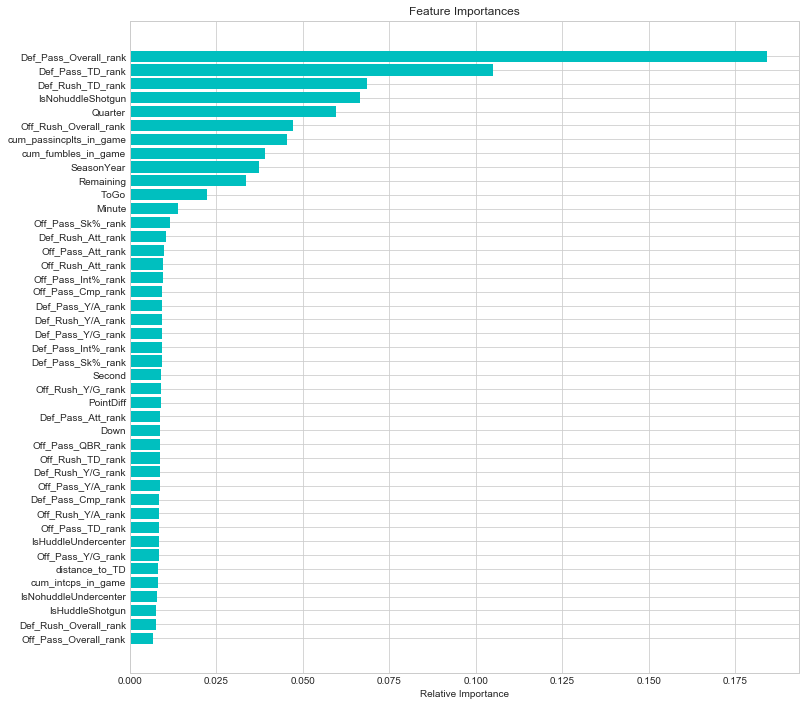

In [204]:
import matplotlib.pyplot as plt
%matplotlib inline
importances = rf_model5.feature_importances_      # rf_model6 is the random forest classifier
indices = np.argsort(importances)
plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='c', align='center')
plt.yticks(indices,features)
plt.xlabel('Relative Importance')

In [123]:
rf_default = RandomForestClassifier(random_state = 42)
# Parameters used by default
print('Default parameters:\n')
print(rf_default.get_params())

Default parameters:

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


<b>Best model: rf_model5</b>

Compute trainset cross validation accuracy

In [205]:
from sklearn.cross_validation import cross_val_score
rf_model5_train_scores = cross_val_score(rf_model5, data[features], data['IsPass'], cv=10, scoring = 'accuracy')
print(rf_model5_train_scores)
print('Mean score = ', rf_model5_train_scores.mean())

[0.72587323 0.72714726 0.72948296 0.73160633 0.72796772 0.72679975
 0.72818008 0.73030367 0.72900074 0.72900074]
Mean score =  0.7285362485847161


Compute testset cross validation accuracy

In [131]:
from sklearn.cross_validation import cross_val_score
rf_model5_scores = cross_val_score(rf_model5, Testdata[features], Testdata['IsPass'], cv=10, scoring = 'accuracy')
print(rf_model5_scores)
print('Mean score = ', rf_model5_scores.mean())

[0.72993631 0.72781316 0.73333333 0.72611465 0.73036093 0.73036093
 0.71210191 0.73078556 0.71695708 0.73140671]
Mean score =  0.7269170584960428


Compute confusion matrix and False Negative Rate

In [132]:
# FN / (TP + FN) 
print(confusion_matrix(Testdata['IsPass'], rf_model5.predict(Testdata[features])))
tn, fp, fn, tp = confusion_matrix(Testdata['IsPass'], rf_model5.predict(Testdata[features])).ravel()
print('False Negative Rate = ', fn/(tp+fn))

[[ 6138  3330]
 [ 2961 11117]]
False Negative Rate =  0.21032817161528627


Draw the ROC curve
- ROC curves of different models are very close and not easy to distinguish because of colors covering each other. Therefore, we don't compare the models using ROC curve. Instead, we compare them in the results table.

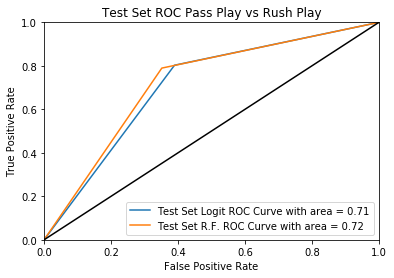

In [136]:
#training_predictions = model.predict(x_train)
#(fpr, tpr, thresholds) = roc_curve(y_train,training_predictions)
from sklearn.metrics import roc_curve, auc
testing_predictions_lg = logit_model10.predict(Testdata[features])
(fpr_lg, tpr_lg, thresholds_lg) = roc_curve(Testdata['IsPass'],testing_predictions_lg)
testing_predictions_rf = rf_model5.predict(Testdata[features])
(fpr_rf, tpr_rf, thresholds_rf) = roc_curve(Testdata['IsPass'],testing_predictions_rf)

area_lg = auc(fpr_lg,tpr_lg)
area_rf = auc(fpr_rf,tpr_rf)
plt.clf() #Clear the current figure
plt.plot(fpr_lg,tpr_lg,label="Test Set Logit ROC Curve with area = %1.2f"%area_lg)
plt.plot(fpr_rf,tpr_rf,label="Test Set R.F. ROC Curve with area = %1.2f"%area_rf)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Pass Play vs Rush Play')
plt.legend(loc="lower right")
plt.show()

<b>Random Hyperparameter Grid</b>
- The right and systematic way to do hyperparameter tuning should be using GridSearchCV. However, in our many trials of using this method, the computational cost is so large that the program runs for so long without giving a result.
- Even in the rf_cv_find_hyperparameter where we use 5 cross-validation, the computational cost is really large.
- Therefore, <b>we don't run the code belowed</b> in the last version of our notebook, but only provide it as a reference and proof that we master such hyperparameter tuning tools.
- Our rf_model5 above should suffice to give a representative result of the Random Forest model.

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1100, num = 5)]
n_estimators

In [ ]:
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)
max_depth

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1100, num = 5)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 5)]
max_depth.append(None)

# Method of selecting samples for training each tree
# bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}

print(random_grid)

# Random Search Training
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfc = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42)

# Fit the random search model
rf_random.fit(train_features_exp, train_lables_exp)
rf_random.best_params_

In [ ]:
def rf_cv_find_hyperparameter():
    model_accuracy = []
    for i in depth_list:
        for j in tree_list:
            model = RandomForestClassifier(max_depth = i, n_estimators = j, random_state = 42)
            model_scores = cross_val_score(model, data[features], data['IsPass'], cv=5, scoring = 'accuracy')
            model_accuracy.append((i,j,model_scores.mean()))
        
#     print('Max testing accuracy: ', testing_accuracy.sort(key = lambda x : x[2])[0][2])
#     print('Depth of the most accurate random forest: ', testing_accuracy.sort(key = lambda x : x[2])[0][0])
#     print('Number of trees of the most accurate random forest: ', testing_accuracy.sort(key = lambda x : x[2])[0][1])

    model_accuracy.sort(key = lambda x : x[2], reverse= True)
    return model_accuracy

cv_model_accuracy = rf_cv_find_hyperparameter()
cv_model_accuracy

<b>Test data accuracy by quarter</b>

In [137]:
def gen_df_byquarter():
    rf_quarter_list = list()
    for i in range(5):
        rf_quarter_list.append(rf_model5.score(Testdata[Testdata['Quarter'] == i+1][features], \
                                                     Testdata[Testdata['Quarter'] == i+1]['IsPass']))
    return rf_quarter_list

rf_quarter_list = gen_df_byquarter()
rf_quarter_list

[0.7010931021485112,
 0.729666562792147,
 0.6992826926613942,
 0.7919344473007712,
 0.7515527950310559]

<b>Test data accuracy by down</b>

In [138]:
def gen_df_bydown():
    rf_down_list = list()
    for i in range(4):
        rf_down_list.append(rf_model5.score(Testdata[Testdata['Down'] == i+1][features],\
                                                     Testdata[Testdata['Down'] == i+1]['IsPass']))
    return rf_down_list

rf_down_list = gen_df_bydown()
rf_down_list

[0.6864463282217355,
 0.7166603702304496,
 0.8535098781000421,
 0.8530259365994236]

# Gradient Boosting Machine

In [139]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

test_features_exp = test[features]
test_labels_exp = test['IsPass']

In [141]:
gbclassifier1 = GradientBoostingClassifier(n_estimators=250)
gbclassifier1.fit(X,y)
print('training accuracy: ', gbclassifier1.score(X,y))
print('testing accuracy: ', gbclassifier1.score(test_features_exp,test_labels_exp))

training accuracy:  0.737686641449333
testing accuracy:  0.7338401426993969


In [142]:
gbclassifier2 = GradientBoostingClassifier(n_estimators=300)
gbclassifier2.fit(X,y)
print('training accuracy: ', gbclassifier2.score(X,y))
print('testing accuracy: ', gbclassifier2.score(test_features_exp,test_labels_exp))

training accuracy:  0.7392394983077842
testing accuracy:  0.734094963051049


In [143]:
gbclassifier3 = GradientBoostingClassifier(n_estimators=400)
gbclassifier3.fit(X,y)
print('training accuracy: ', gbclassifier3.score(X,y))
print('testing accuracy: ', gbclassifier3.score(test_features_exp,test_labels_exp))

training accuracy:  0.7413630632424182
testing accuracy:  0.7347320139301792


In [144]:
gbclassifier4 = GradientBoostingClassifier(n_estimators=350)
gbclassifier4.fit(X,y)
print('training accuracy: ', gbclassifier4.score(X,y))
print('testing accuracy: ', gbclassifier4.score(test_features_exp,test_labels_exp))

training accuracy:  0.7399960183157476
testing accuracy:  0.734222373226875


In [145]:
gbclassifier5 = GradientBoostingClassifier(n_estimators=360, random_state=42)
gbclassifier5.fit(X,y)
print('training accuracy: ', gbclassifier5.score(X,y))
print('testing accuracy: ', gbclassifier5.score(test_features_exp,test_labels_exp))

training accuracy:  0.7403278253367841
testing accuracy:  0.7343073133440924


In [146]:
gbclassifier6 = GradientBoostingClassifier(n_estimators=370, random_state=42)
gbclassifier6.fit(X,y)
print('training accuracy: ', gbclassifier6.score(X,y))
print('testing accuracy: ', gbclassifier6.score(test_features_exp,test_labels_exp))

training accuracy:  0.7406198155152963
testing accuracy:  0.7350717743990487


In [147]:
gbclassifier7 = GradientBoostingClassifier(n_estimators=340, random_state=42)
gbclassifier7.fit(X,y)
print('training accuracy: ', gbclassifier7.score(X,y))
print('testing accuracy: ', gbclassifier7.score(test_features_exp,test_labels_exp))

training accuracy:  0.7401154688433207
testing accuracy:  0.7345196636371358


In [148]:
gbclassifier8 = GradientBoostingClassifier(n_estimators=330, random_state=42)
gbclassifier8.fit(X,y)
print('training accuracy: ', gbclassifier8.score(X,y))
print('testing accuracy: ', gbclassifier8.score(test_features_exp,test_labels_exp))

training accuracy:  0.73983675094565
testing accuracy:  0.7344771935785271


In [149]:
gbclassifier10 = GradientBoostingClassifier(n_estimators=350, random_state=42)
gbclassifier10.fit(X,y)
print('training accuracy: ', gbclassifier10.score(X,y))
print('testing accuracy: ', gbclassifier10.score(test_features_exp,test_labels_exp))

training accuracy:  0.7399960183157476
testing accuracy:  0.734222373226875


Show feature importances

In [153]:
gbclassifier6.feature_importances_

array([2.44330493e-06, 3.41718701e-02, 2.83454300e-02, 1.57527524e-01,
       7.89272102e-02, 9.20992666e-02, 7.78100611e-03, 1.17371878e-01,
       1.63058625e-02, 1.43220504e-02, 1.57631292e-02, 6.10235486e-03,
       1.63948642e-02, 9.21845835e-03, 1.03783735e-02, 1.31299506e-02,
       1.23428404e-02, 1.14019129e-02, 7.07054617e-03, 1.13336171e-02,
       9.39860395e-03, 7.25020040e-03, 8.02371257e-03, 8.14542618e-03,
       6.35588261e-03, 6.57415247e-03, 8.96535775e-03, 9.58950845e-03,
       5.69929830e-03, 7.05287020e-03, 7.29473493e-03, 1.00029487e-02,
       9.01474028e-03, 3.50095343e-03, 3.63446973e-03, 4.60906312e-03,
       6.63492470e-02, 1.40556023e-02, 1.11900958e-02, 7.93079342e-02,
       1.02100684e-02, 1.18454987e-02, 3.19390420e-02])

Text(0.5,0,'Relative Importance')

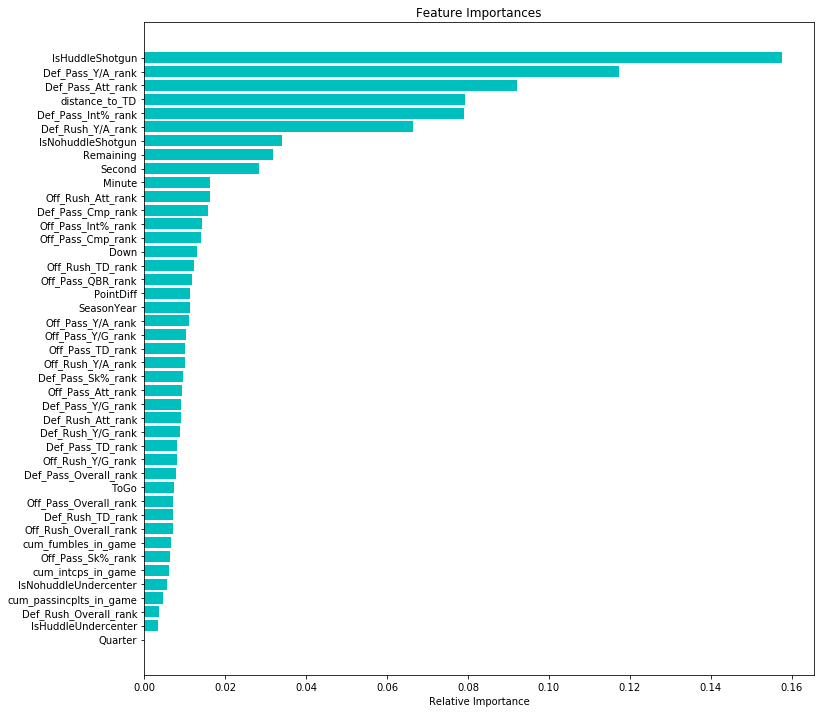

In [154]:
import matplotlib.pyplot as plt
%matplotlib inline
importances = gbclassifier6.feature_importances_      # gbclassifier10 is the random forest classifier
indices = np.argsort(importances)
plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='c', align='center')
plt.yticks(indices,features)
plt.xlabel('Relative Importance')

<b>Best Model: gbclassifier6</b>

Compute trainset cross validation accuracy

In [152]:
# 10-fold valodation for 15 iterations using gbclassifier6
def gbmodel_cross_validation(iteration):
    score_list = []
    meanscore_list = []
    for i in range(iteration): 
        gbmodel_scores = cross_val_score(gbclassifier6, data[features], data['IsPass'], cv=10, scoring='accuracy')
        meanscore_list.append(gbmodel_scores.mean())
        score_list.extend(gbmodel_scores)
    return score_list, meanscore_list

In [151]:
gb_score_list, gb_meanscore_list = gbmodel_cross_validation(2)
print(gb_score_list)
print(gb_meanscore_list)

[0.7318186644017411, 0.7346852107442403, 0.7272534239303535, 0.732986516615352, 0.7323210872796773, 0.7334890634954343, 0.7361435548948821, 0.7368868124867275, 0.733991717107359, 0.7348412445577148, 0.7318186644017411, 0.7346852107442403, 0.7272534239303535, 0.732986516615352, 0.7323210872796773, 0.7334890634954343, 0.7361435548948821, 0.7368868124867275, 0.733991717107359, 0.7348412445577148]
[0.7334417295513481, 0.7334417295513481]


Compute testset cross validation accuracy

In [155]:
gbclassifier6.score(testdata[features], testdata['IsPass'])

0.7316982534373839

In [156]:
print(confusion_matrix(testdata['IsPass'], gbclassifier6.predict(testdata[features])))
tn, fp, fn, tp = confusion_matrix(testdata['IsPass'], gbclassifier10.predict(testdata[features])).ravel()
print('False Negative Rate = ', fn/(tp+fn))

[[5177 2734]
 [2320 8606]]
False Negative Rate =  0.21252059308072488


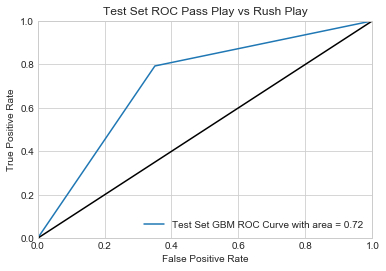

In [175]:
#training_predictions = model.predict(x_train)
#(fpr, tpr, thresholds) = roc_curve(y_train,training_predictions)
from sklearn.metrics import roc_curve, auc
testing_predictions_gb = gbclassifier6.predict(Testdata[features])
(fpr_gb, tpr_gb, thresholds_gb) = roc_curve(Testdata['IsPass'],testing_predictions_gb)

area_gb = auc(fpr_gb,tpr_gb)
plt.clf() #Clear the current figure
plt.plot(fpr_gb,tpr_gb,label="Test Set GBM ROC Curve with area = %1.2f"%area_gb)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Pass Play vs Rush Play')
plt.legend(loc="lower right")
plt.show()

<b>Using new features and the best model, do one more time</b>

In [158]:
gbmodel6_scores_new = cross_val_score(gbclassifier6, data[new_features], data['IsPass'], cv=10, scoring='accuracy')

In [159]:
print(gbmodel6_scores_new.mean())
print(gbmodel6_scores_new)

0.7332293770053007
[0.72884595 0.73330502 0.73022614 0.73468521 0.73221491 0.73348906
 0.73412614 0.73561266 0.73367314 0.73611554]


<b>Test data accuracy by quarter</b>

In [161]:
def gen_df_byquarter():
    gbm_quarter_list = list()
    for i in range(5):
        gbm_quarter_list.append(gbclassifier6.score(Testdata[Testdata['Quarter'] == i+1][features], \
                                                     Testdata[Testdata['Quarter'] == i+1]['IsPass']))
    return gbm_quarter_list

gbm_quarter_list = gen_df_byquarter()
gbm_quarter_list

[0.7016584998115342,
 0.7352757868494858,
 0.7014897921647968,
 0.7922557840616966,
 0.7515527950310559]

<b>Test data accuracy by down</b>

In [162]:
def gen_df_bydown():
    gbm_down_list = list()
    for i in range(4):
        gbm_down_list.append(gbclassifier6.score(Testdata[Testdata['Down'] == i+1][features],\
                                                     Testdata[Testdata['Down'] == i+1]['IsPass']))
    return gbm_down_list

gbm_down_list = gen_df_bydown()
gbm_down_list

[0.682350700066673, 0.7272383830751794, 0.8545607398066415, 0.8703170028818443]

# XGBoosting

In [169]:
!pip install XGBoost

In [170]:
from xgboost import XGBClassifier

xgbmodel1 = XGBClassifier()
xgbmodel1.fit(X, y)
print('training accuracy: ', xgbmodel1.score(X,y))
print('testing accuracy: ', xgbmodel1.score(test_features_exp,test_labels_exp))

training accuracy:  0.7313424912071139
testing accuracy:  0.7309521787140066


D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Compute trainset cross validation accuracy

In [171]:
xgbmodel_scores = cross_val_score(xgbmodel1, data[features], data['IsPass'], cv=10, scoring='accuracy')
print(xgbmodel_scores.mean())
print(xgbmodel_scores)

D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.si

0.7290672043629742
[0.72693492 0.72714726 0.72619174 0.73128782 0.7286048  0.72722446
 0.72945424 0.73295817 0.72900074 0.7318679 ]


D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Text(0.5,0,'Relative Importance')

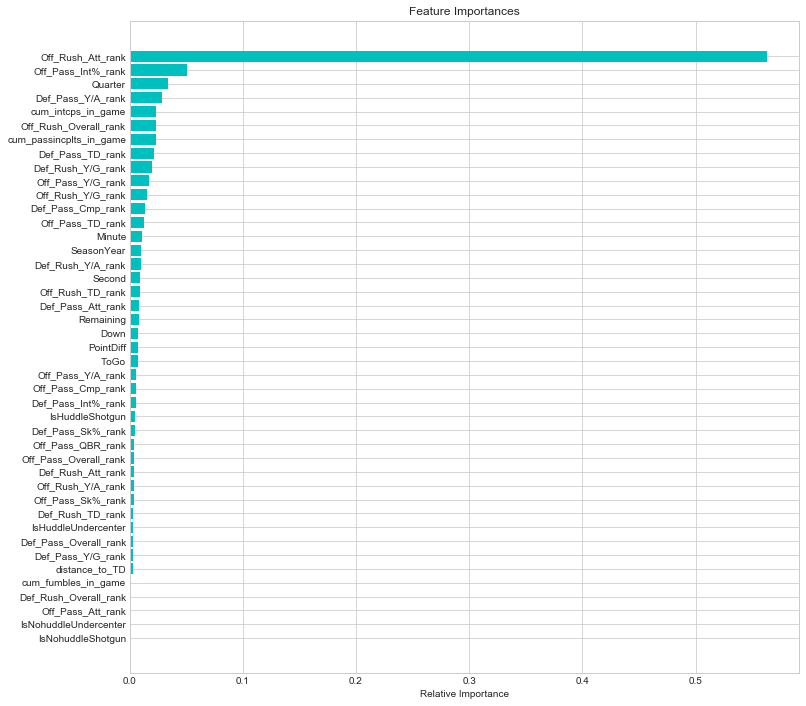

In [172]:
import matplotlib.pyplot as plt
%matplotlib inline
importances = xgbmodel1.feature_importances_      # gbclassifier10 is the random forest classifier
indices = np.argsort(importances)
plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='c', align='center')
plt.yticks(indices,features)
plt.xlabel('Relative Importance')

Compute testset cross validation accuracy

In [207]:
xgbmodel1_test_scores = cross_val_score(xgbmodel1, testdata[features], testdata['IsPass'], cv=10, scoring='accuracy')
print(xgbmodel1_test_scores.mean())
print(xgbmodel1_test_scores)

D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.si

0.7255405515575981
[0.72785146 0.72292994 0.73142251 0.73566879 0.72133758 0.70435244
 0.72012746 0.73340414 0.71694105 0.74137015]


D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Compute the confusion matrix

In [174]:
print(confusion_matrix(testdata['IsPass'], xgbmodel1.predict(testdata[features])))
tn, fp, fn, tp = confusion_matrix(testdata['IsPass'], xgbmodel1.predict(testdata[features])).ravel()
print('False Negative Rate = ', fn/(tp+fn))

[[5051 2860]
 [2271 8655]]
False Negative Rate =  0.20785282811641956


D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


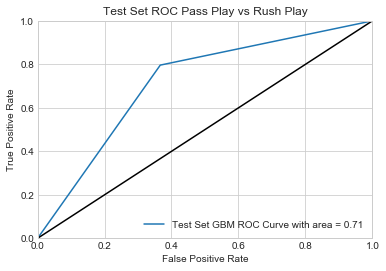

In [176]:
#training_predictions = model.predict(x_train)
#(fpr, tpr, thresholds) = roc_curve(y_train,training_predictions)
from sklearn.metrics import roc_curve, auc
testing_predictions_xgb = xgbmodel1.predict(Testdata[features])
(fpr_xgb, tpr_xgb, thresholds_xgb) = roc_curve(Testdata['IsPass'],testing_predictions_xgb)

area_xgb = auc(fpr_xgb,tpr_xgb)
plt.clf() #Clear the current figure
plt.plot(fpr_xgb,tpr_xgb,label="Test Set XGB ROC Curve with area = %1.2f"%area_xgb)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Pass Play vs Rush Play')
plt.legend(loc="lower right")
plt.show()

</b>Test data accuracy by quarter</b>

In [177]:
def gen_df_byquarter():
    xgb_quarter_list = list()
    for i in range(5):
        xgb_quarter_list.append(xgbmodel1.score(Testdata[Testdata['Quarter'] == i+1][features], \
                                                     Testdata[Testdata['Quarter'] == i+1]['IsPass']))
    return xgb_quarter_list

xgb_quarter_list = gen_df_byquarter()
xgb_quarter_list

D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.si

[0.6988315114964192,
 0.7302898099096292,
 0.6956041934890564,
 0.7887210796915167,
 0.7763975155279503]

<b>Test data accuracy by down</b>

In [178]:
def gen_df_bydown():
    xgb_down_list = list()
    for i in range(4):
        xgb_down_list.append(xgbmodel1.score(Testdata[Testdata['Down'] == i+1][features],\
                                                     Testdata[Testdata['Down'] == i+1]['IsPass']))
    return xgb_down_list

xgb_down_list = gen_df_bydown()
xgb_down_list

D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.si

[0.6822554529002762,
 0.7180455861982118,
 0.8507776376628836,
 0.8587896253602305]

# Linear Discriminant Analysis
- Though there's collinearity in the LDA model, we still accept the result to obtain better prediction accuracy.

In [179]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cross_validation import cross_val_score

In [180]:
lda = LDA(n_components=1)
lda_model1 = lda.fit(X, y)
print('training accuracy: ', lda_model1.score(X,y))
print('testing accuracy: ', lda_model1.score(test_features_exp,test_labels_exp))

training accuracy:  0.7206583051297365
testing accuracy:  0.7260681219740083


D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Compute trainset cross validation accuracy

In [181]:
lda_scores = cross_val_score(lda_model1, data[features], data['IsPass'], cv=10, scoring='accuracy')
print(lda_scores.mean())
print(lda_scores)

D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are colli

0.7204561649883642
[0.71674275 0.71982164 0.71875995 0.72587323 0.71947335 0.71851773
 0.72021661 0.7223402  0.72114261 0.72167357]


D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Compute testset cross validation accuracy

In [209]:
lda_model1.score(testdata[features], testdata['IsPass'])
lda_test_scores = cross_val_score(lda_model1, testdata[features], testdata['IsPass'], cv=10, scoring='accuracy')
print(lda_test_scores.mean())
print(lda_test_scores)

D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are colli

0.7210811072125928
[0.72838196 0.71443737 0.72823779 0.73089172 0.71284501 0.69957537
 0.71109931 0.72703133 0.72065852 0.73765268]


D:\Anaconda\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Compute the confusion matrix

In [183]:
print(confusion_matrix(testdata['IsPass'], lda_model1.predict(testdata[features])))
tn, fp, fn, tp = confusion_matrix(testdata['IsPass'], lda_model1.predict(testdata[features])).ravel()
print('False Negative Rate = ', fn/(tp+fn))

[[4871 3040]
 [2217 8709]]
False Negative Rate =  0.2029104887424492


D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


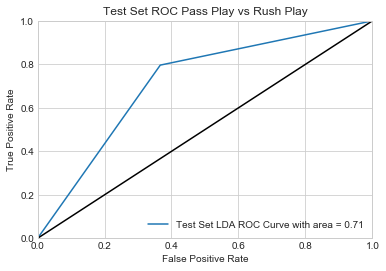

In [184]:
#training_predictions = model.predict(x_train)
#(fpr, tpr, thresholds) = roc_curve(y_train,training_predictions)
from sklearn.metrics import roc_curve, auc
testing_predictions_lda = xgbmodel1.predict(Testdata[features])
(fpr_lda, tpr_lda, thresholds_lda) = roc_curve(Testdata['IsPass'],testing_predictions_lda)

area_lda = auc(fpr_lda,tpr_lda)
plt.clf() #Clear the current figure
plt.plot(fpr_lda,tpr_lda,label="Test Set LDA ROC Curve with area = %1.2f"%area_lda)

plt.plot([0, 1], [0, 1], 'k')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Pass Play vs Rush Play')
plt.legend(loc="lower right")
plt.show()

<b>Test data accuracy by quarter</b>

In [187]:
def gen_df_byquarter():
    lda_quarter_list = list()
    for i in range(5):
        lda_quarter_list.append(lda_model1.score(Testdata[Testdata['Quarter'] == i+1][features], \
                                                     Testdata[Testdata['Quarter'] == i+1]['IsPass']))
    return lda_quarter_list

lda_quarter_list = gen_df_byquarter()
lda_quarter_list

[0.6958160572936298,
 0.7262387036459956,
 0.6910060695236343,
 0.781491002570694,
 0.7577639751552795]

<b>Test data accuracy by down</b>

In [188]:
def gen_df_bydown():
    lda_down_list = list()
    for i in range(4):
        lda_down_list.append(lda_model1.score(Testdata[Testdata['Down'] == i+1][features],\
                                                     Testdata[Testdata['Down'] == i+1]['IsPass']))
    return lda_down_list

lda_down_list = gen_df_bydown()
lda_down_list

[0.6792075435755787,
 0.7093565042186123,
 0.8495166036149643,
 0.8357348703170029]

# Test data accuracy by quarter --- Summary

In [191]:
logit_quarter_list = [0.6956275914059555, 0.7256154565285136, 0.6906382196064006, 0.7802056555269923, 0.7639751552795031]
rf_quarter_list = [0.7010931021485112,0.729666562792147,0.6992826926613942,0.7919344473007712,0.7515527950310559]
gbm_quarter_list = [0.7016584998115342,0.7352757868494858,0.7014897921647968,0.7922557840616966,0.7515527950310559]
xgb_quarter_list = [0.6988315114964192,0.7302898099096292,0.6956041934890564,0.7887210796915167,0.7763975155279503]
lda_quarter_list = [0.6958160572936298,0.7262387036459956,0.6910060695236343,0.781491002570694,0.7577639751552795]

In [193]:
df_byquarter = pd.DataFrame({'quarter': range(1,6), 'Logit': logit_quarter_list, 'LDA': lda_quarter_list, 'R_F': rf_quarter_list,\
                             'GBM': gbm_quarter_list ,'XGB' : xgb_quarter_list})
df_byquarter

,quarter,Logit,LDA,R_F,GBM,XGB
0,1,0.695628,0.695816,0.701093,0.701658,0.698832
1,2,0.725615,0.726239,0.729667,0.735276,0.730290
2,3,0.690638,0.691006,0.699283,0.701490,0.695604
3,4,0.780206,0.781491,0.791934,0.792256,0.788721
4,5,0.763975,0.757764,0.751553,0.751553,0.776398


Text(0,0.5,'Test Set Prediction Accuracy')

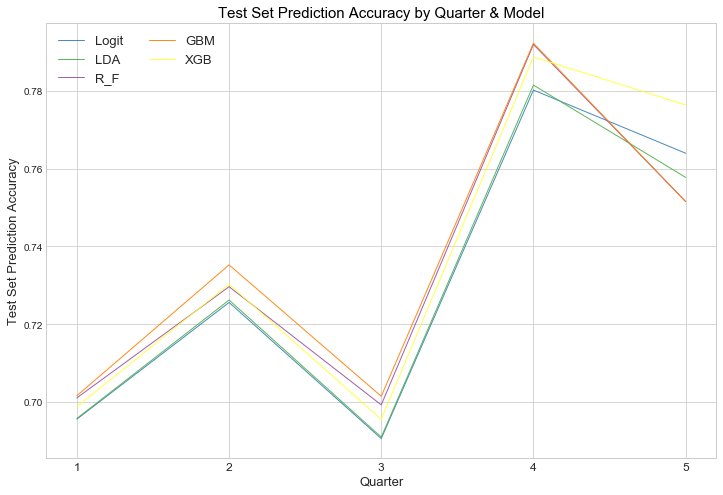

In [194]:
plt.figure(figsize=(12,8))
# Make a data frame
dfsp=df_byquarter
 
# style
plt.style.use('seaborn-whitegrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in dfsp.drop('quarter', axis=1):
    num+=1
    plt.plot(dfsp['quarter'], dfsp[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)

# Add legend
plt.legend(loc=2, ncol=2, fontsize = 13)
 
# Add titles
plt.title("Test Set Prediction Accuracy by Quarter & Model", loc='center', fontsize=15, fontweight=0, color='black')
plt.xlabel("Quarter", fontsize = 13)
plt.xticks([1,2,3,4,5], fontsize = 12)
plt.ylabel("Test Set Prediction Accuracy", fontsize = 13)


# Test data accuracy by down --- Summary

In [195]:
logit_down_list = [0.679493285074769, 0.7104898627376904, 0.8451029844472467, 0.8213256484149856]
rf_down_list = [0.6864463282217355,0.7166603702304496,0.8535098781000421,0.8530259365994236]
lda_down_list = [0.6792075435755787,0.7093565042186123,0.8495166036149643,0.8357348703170029]
xgb_down_list = [0.6822554529002762,0.7180455861982118,0.8507776376628836,0.8587896253602305]
gbm_down_list = [0.682350700066673, 0.7272383830751794, 0.8545607398066415, 0.8703170028818443]

In [196]:
df_bydown = pd.DataFrame({'down': range(1,5), 'Logit': logit_down_list, 'LDA': lda_down_list, 'R_F': rf_down_list,\
                          'GBM': gbm_down_list ,'XGB' : xgb_down_list})
df_bydown

,down,Logit,LDA,R_F,GBM,XGB
0,1,0.679493,0.679208,0.686446,0.682351,0.682255
1,2,0.710490,0.709357,0.716660,0.727238,0.718046
2,3,0.845103,0.849517,0.853510,0.854561,0.850778
3,4,0.821326,0.835735,0.853026,0.870317,0.858790


Text(0,0.5,'Test Set Prediction Accuracy')

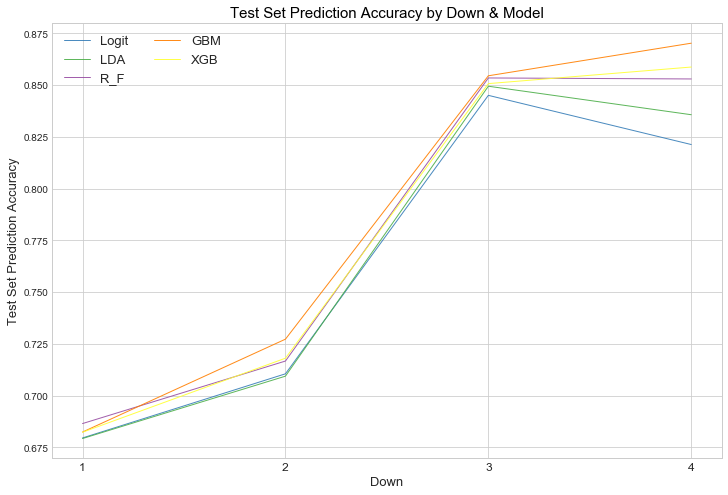

In [197]:
plt.figure(figsize=(12,8))
# style
plt.style.use('seaborn-whitegrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in df_bydown.drop('down', axis=1):
    num+=1
    plt.plot(df_bydown['down'], df_bydown[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)

# Add legend
plt.legend(loc=2, ncol=2, fontsize = 13)
 
# Add titles
plt.title("Test Set Prediction Accuracy by Down & Model", loc='center', fontsize=15, fontweight=0, color='black')
plt.xlabel("Down", fontsize = 13)
plt.xticks([1,2,3,4], fontsize = 12)
plt.ylabel("Test Set Prediction Accuracy", fontsize = 13)


# Test data accuracy by Team --- Summary

In [198]:
teamlist = Testdata['OffenseTeam'].unique()
teamlist

array(['ARI', 'CAR', 'WAS', 'PIT', 'DAL', 'LAR', 'OAK', 'TEN', 'NYJ',
       'HOU', 'NO', 'DEN', 'KC', 'MIN', 'IND', 'JAX', 'DET', 'ATL', 'CHI',
       'MIA', 'TB', 'SF', 'BAL', 'NYG', 'PHI', 'SEA', 'BUF', 'CLE', 'GB',
       'LAC', 'NE', 'CIN'], dtype=object)

In [199]:
def gen_df_byteam():
    gbm_teamaccuracy_list = list()
    for i in range(len(teamlist)):
        gbm_teamaccuracy_list.append(gbclassifier6.score(Testdata[Testdata['OffenseTeam'] == teamlist[i]][features],\
                                                     Testdata[Testdata['OffenseTeam'] == teamlist[i]]['IsPass']))
    return gbm_teamaccuracy_list

gbm_teamaccuracy_list = gen_df_byteam()
gbm_teamaccuracy_list

[0.7579529737206085,
 0.7142857142857143,
 0.7225433526011561,
 0.7588466579292268,
 0.7747625508819539,
 0.7637906647807637,
 0.7294429708222812,
 0.7523809523809524,
 0.703862660944206,
 0.7070572569906791,
 0.7873183619550859,
 0.7520435967302452,
 0.7116736990154712,
 0.7496635262449529,
 0.7334254143646409,
 0.7408854166666666,
 0.728744939271255,
 0.7238605898123325,
 0.7575757575757576,
 0.7404129793510325,
 0.7586633663366337,
 0.6978609625668449,
 0.6819923371647509,
 0.7676056338028169,
 0.7092866756393001,
 0.6807065217391305,
 0.6780626780626781,
 0.7542857142857143,
 0.708502024291498,
 0.7807486631016043,
 0.763681592039801,
 0.7276720351390923]

In [200]:
df_byteam = pd.DataFrame({'team':teamlist, 'test_accuracy':gbm_teamaccuracy_list})
sorted_df = df_byteam.sort_values(by = 'test_accuracy', ascending=False)
sorted_df

,team,test_accuracy
10,NO,0.787318
29,LAC,0.780749
4,DAL,0.774763
23,NYG,0.767606
5,LAR,0.763791
30,NE,0.763682
3,PIT,0.758847
20,TB,0.758663
0,ARI,0.757953
18,CHI,0.757576


Text(0,0.5,'Test Set Prediction Accuracy (%)')

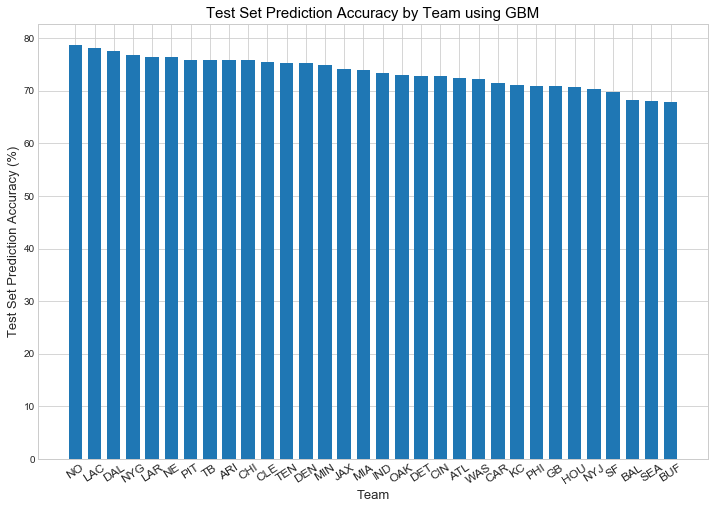

In [201]:
plt.figure(figsize=(12,8))
# style
plt.style.use('seaborn-whitegrid')
plt.bar(sorted_df['team'],sorted_df['test_accuracy']*100, width = 0.7)
# Add titles
plt.title("Test Set Prediction Accuracy by Team using GBM", loc='center', fontsize=15, fontweight=0, color='black')
plt.xlabel("Team", fontsize = 13)
plt.xticks(teamlist, fontsize = 12, rotation = 33)
plt.ylabel("Test Set Prediction Accuracy (%)", fontsize = 13)
